In [114]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn
import os
import numpy as np
from scipy.optimize import curve_fit

In [115]:
# functions for reading data

def read_data_potentials_T(paths, sigma):
    data = []
    for key, value in paths.items():
        data.append(pd.read_csv(value[0], index_col=None))
        if len(value) >= 3:
            data[-1] = data[-1][data[-1]['smearing_step'] == value[2]]
        data[-1] = data[-1][data[-1]['T'] == value[1]]
        data[-1] = data[-1].drop(['T'], axis = 1)
        data[-1].reset_index(drop=True, inplace=True)
        data[-1] = data[-1].rename(columns={'aV(r)': f'aV(r)_{key}', 'err': f'err_{key}'})
        data[-1]['r/a'] = data[-1]['r/a'] * math.sqrt(sigma)
        data[-1][f'aV(r)_{key}'] = data[-1][f'aV(r)_{key}'] / math.sqrt(sigma)
        data[-1][f'err_{key}'] = data[-1][f'err_{key}'] / math.sqrt(sigma)
    data = pd.concat(data, axis = 1)
    data = data.loc[:,~data.columns.duplicated()]

    return data

def read_data_potentials_together(paths, sigma):
    data = []
    for key, value in paths.items():
        print(key)
        data.append(pd.read_csv(value[0], index_col=None))
        if len(value) >= 3:
            data[-1] = data[-1][data[-1]['smearing_step'] == value[2]]
        data[-1] = data[-1][data[-1]['T'] == value[1]]
        data[-1] = data[-1].drop(['T'], axis = 1)
        data[-1].reset_index(drop=True, inplace=True)
        data[-1]['r/a'] = data[-1]['r/a'] * math.sqrt(sigma)
        data[-1][f'aV(r)'] = data[-1][f'aV(r)'] / math.sqrt(sigma)
        data[-1][f'err'] = data[-1][f'err'] / math.sqrt(sigma)
        data[-1]['type'] = key
    data = pd.concat(data)
    # data = data.loc[:,~data.columns.duplicated()]

    return data

def read_data_potentials(paths, sigma):
    data = []
    for path in paths:
        data.append(pd.read_csv(path['path'], index_col=None))
        if 'smearing' in path:
            data[-1] = data[-1][data[-1]['smearing_step'] == path['smearing']]
        # if 'T' in path:
        #     data[-1] = data[-1][data[-1]['T'] == path['T']]
        data[-1].reset_index(drop=True, inplace=True)
        name = path['name']
        data[-1] = data[-1].rename(columns={'aV(r)': f'aV(r)_{name}', 'err': f'err_{name}'})
        data[-1]['r/a'] = data[-1]['r/a'] * math.sqrt(sigma)
        data[-1][f'aV(r)_{name}'] = data[-1][f'aV(r)_{name}'] / math.sqrt(sigma)
        data[-1][f'err_{name}'] = data[-1][f'err_{name}'] / math.sqrt(sigma)
    data = pd.concat(data, axis = 1)
    data = data.loc[:,~data.columns.duplicated()]

    return data

def read_file_vitaliy(file_path, T_max):
    if(os.path.isfile(file_path)):
        df = []
        with open(file_path, 'r') as f:
            lines = f.readlines()

            R_sizes = []
            T_sizes = list(range(1, T_max + 1))
            for line in lines:
                line_split = line.split()
                R_sizes = [int(line_split[0])] * T_max
                line_potential = []
                line_err = []
                for i in range(3):
                    line_potential.append([float(i) for i in line_split[1 + i * (2 * T_max + 1) : T_max + 1 + i * (2 * T_max + 1)]])
                    line_err.append([float(i) for i in line_split[T_max + 1 + i * (2 * T_max + 1) : 2 * T_max + 1 + i * (2 * T_max + 1)]])

                df.append(pd.DataFrame({'R': R_sizes, 'T': T_sizes, 'potential_monopole': line_potential[0], 'err_monopole': line_err[0],
                'potential_monopoless': line_potential[1], 'err_monopoless': line_err[1],
                'potential_su2': line_potential[2], 'err_su2': line_err[2]}))

            return pd.concat(df)

def read_data_potential_vitaliy():
    data = []
    data.append(read_file_vitaliy('../result/potential/on-axis/su2/vitaliy/pot_vs_r_all3_B2p4.dat', 11))
    data[-1]['beta'] = float(2.4)
    data[-1]['sigma'] = float(0.258265528440037)
    data.append(read_file_vitaliy('../result/potential/on-axis/su2/vitaliy/pot_vs_r_all3_B2p5.dat', 11))
    data[-1]['beta'] = float(2.5)
    data[-1]['sigma'] = float(0.181839887534859)
    data.append(read_file_vitaliy('../result/potential/on-axis/su2/vitaliy/pot_vs_r_all3_b2p6_L32.dat', 15))
    data[-1]['beta'] = float(2.6)
    data[-1]['sigma'] = float(0.134725276024954)

    return pd.concat(data)

In [131]:
def save_image(image_path, image_name, fg):
    try:
        os.makedirs(image_path)
    except:
        pass
    
    output_path = f'{image_path}/{image_name}'
    print(output_path)
    fg.savefig(output_path, dpi=400, facecolor='white')

def plot_relative_variation_potential(data):
    # T = data['T'].iloc[0]
    # sigma = data['sigma'].iloc[0]
    fg = seaborn.FacetGrid(data=data, hue = 'beta', height=5, aspect=1.2)
    fg.fig.suptitle(f'relative variation')
    fg.map(plt.errorbar, 'R', 'potential_diff', 'err_diff', marker="o", fmt='', linestyle = ''
    ).add_legend()
    fg.ax.set_xlabel(r"r$\sqrt{\sigma}$")
    fg.ax.set_ylabel(r"$\Delta$")
    plt.xlim((0, 2.5))
    plt.ylim((-0.3, 0.3))
    fg.ax.spines['right'].set_visible(True)
    fg.ax.spines['top'].set_visible(True)
    fg.ax.minorticks_on()
    fg.ax.tick_params(which = 'both', bottom = True, top = True, left = True, right = True)
    plt.axhline(y = 0, color = 'k', linestyle = '-')
    # plt.show()

    save_image(f'../images/potential/relative_variation/vitaliy', f'relative_variation', fg)

def choose_data(data, T_sizes):
    data_new = []
    for beta in [2.4, 2.5, 2.6]:
        df = []
        df1 = data[data['beta'] == beta]
        for monopole in ['monopole', 'monopoless', 'su2']:
            df.append(df1[df1['T'] == T_sizes[beta][monopole]][['R', f'potential_{monopole}', f'err_{monopole}', 'beta', 'sigma']])

        df[-1] = df[-1].reset_index()
        df[-2] = df[-2].reset_index()
        df[-3] = df[-3].reset_index()

        df = pd.concat(df, axis = 1).reset_index()
        df = df.loc[:,~df.columns.duplicated()]
        data_new.append(df)

    return pd.concat(data_new)
        
def relative_variation_potential():
    data = read_data_potential_vitaliy()

    T_sizes = {2.4: {'monopole': 5, 'monopoless': 6, 'su2': 8}, 
        2.5: {'monopole': 5, 'monopoless': 6, 'su2': 8}, 
        2.6: {'monopole': 7, 'monopoless': 6, 'su2': 9}}
    data = choose_data(data, T_sizes)

    data = data[data['potential_su2'] != 0.0]

    data['potential_diff'] = data.apply(lambda x: x['potential_su2'] - x['potential_monopole'] - x['potential_monopoless'], axis=1)
    data['err_diff'] = data.apply(lambda x: math.sqrt(x['err_su2'] ** 2 + x['err_monopole'] ** 2 + x['err_monopoless'] ** 2), axis=1)
    data['err_diff'] = data.apply(lambda x: math.sqrt(x['err_diff'] ** 2 / x['potential_su2'] ** 2 + x['err_su2'] ** 2 * x['potential_diff'] ** 2 / x['potential_su2'] ** 4), axis=1)
    data['potential_diff'] = data.apply(lambda x: x['potential_diff'] / x['potential_su2'], axis=1)

    data['R'] = data.apply(lambda x: x['R'] * x['sigma'], axis = 1)

    plot_relative_variation_potential(data)


def plot_potential_decomposition(data, y_lims, ls_arr, image_path, image_name):
    colors = ['mediumblue', 'orange', 'g', 'r']
    fg = seaborn.FacetGrid(data=data, hue = 'matrix_type', height=5, aspect=1.4, legend_out=False, 
    hue_kws={"ls" : ls_arr, "marker" : ['o', 'v', 'o', '^'], 
    "fillstyle" : ['full', 'full', 'none', 'full'],"color" : colors})
    map = fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', ms = 8, capsize = 8, lw = 0.5).add_legend(title='')
    fg.ax.set_xlabel(r"R$/r_{0}$")
    fg.ax.set_ylabel(r"$r_{0}V(R)$")
    fg.ax.spines['right'].set_visible(True)
    fg.ax.spines['top'].set_visible(True)
    fg.ax.minorticks_on()
    fg.ax.tick_params(which = 'both', bottom = True, top = True, left = True, right = True)
    fg.ax.set_ylim(y_lims[0], y_lims[1])

    return fg

def join_back(data, matrix_types):
    data1 = []
    for matrix_type in matrix_types:
        data1.append(data[['r/a', f'aV(r)_{matrix_type}', f'err_{matrix_type}']])
        data1[-1] = data1[-1].rename(columns={f'aV(r)_{matrix_type}': 'aV(r)', f'err_{matrix_type}': 'err'})
        data1[-1]['matrix_type'] = matrix_type

    return pd.concat(data1)

def find_sum(data, term1, term2, sum):
    data[f'err_' + sum] = data.apply(lambda x: math.sqrt(x[f'err_' + term1] ** 2 + x[f'err_' + term2] ** 2), axis = 1)
    data[f'aV(r)_' + sum] = data.apply(lambda x: x[f'aV(r)_' + term1] + x[f'aV(r)_' + term2], axis = 1)

    return data

def func_exponent(x, a, b, c):
    return a + b * np.exp(-x * c)

def func_quark_potential(x, c, alpha, sigma):
    return c + alpha * np.power(x, -1) + sigma * x

def func_coloumb(x, c, alpha):
    return c + alpha * np.power(x, -1)

def func_linear(x, c, sigma):
    return c + sigma * x

def fit_potential(data, fit_function, fit_range, fit_name):
    data = data[(data['T'] >= fit_range[0]) & (data['T'] <= fit_range[1])]
    y = data['aV(r)_' + fit_name]
    x = data['T']
    try:
        popt, pcov = curve_fit(fit_function, x, y)
        val = popt[0]
        err = pcov[0][0]
    except:
        val = data.loc[data['T'] == 5, 'aV(r)_' + fit_name].iloc[0]
        err = data.loc[data['T'] == 5, 'err_' + fit_name].iloc[0]
    return pd.DataFrame([[val, err]], columns = ['aV(r)_' + fit_name, 'err_' + fit_name])
    

def get_potential_fit(data, fit_func, fit_range, fit_name):
    return data.groupby(['r/a']).apply(fit_potential, fit_func, fit_range, fit_name).reset_index('r/a').reset_index()

def fit_string(data, fit_range, fit_name):
    data = data[(data['r/a'] >= fit_range[0]) & (data['r/a'] <= fit_range[1])]
    y = data['aV(r)_' + fit_name]
    x = data['r/a']
    popt, pcov = curve_fit(func_quark_potential, x, y)
    return popt

def fit_consts(data, coloumb_name, string_name, alpha, sigma):
    y_coloumb = data['aV(r)_' + coloumb_name]
    y_string = data['aV(r)_' + string_name]
    x = data['r/a']
    c_coloumb, err_coloumb = curve_fit(lambda x, c: c + alpha * np.power(x, -1), x, y_coloumb)
    c_string, err_string = curve_fit(lambda x, c: c + sigma * x, x, y_string)
    return c_coloumb, c_string

def chi_square(x, y, c, alpha, sigma):
    chi_sq = 0
    for i in range(len(x)):
        expected = func_quark_potential(x[i], c, alpha, sigma)
        chi_sq += (expected - y[i])**2 / expected
    return chi_sq

# find a/r_0 for 5.7 <= beta <= 6.92
def get_r0(beta):
    return math.exp(-1.6804 - 1.7331 * (beta - 6) + 0.7849 * (beta - 6)**2 - 0.4428 * (beta - 6)**3)

def potential_decomposition(paths, image_path, image_name, sigma, beta, r_max, y_lims, orig_pot_name, coloumb_name, string_name, fit_type):
    data = read_data_potentials(paths, sigma)

    data = data[data['r/a'] <= r_max]
    data1 = []
    for dict in paths:
        if 'T' in dict:
            data1.append(data[data['T'] == dict['T']].reset_index()[['r/a', 'aV(r)_' + dict['name'], 'err_' + dict['name']]])
        else:
            data1.append(get_potential_fit(data, func_exponent, (2, 7), dict['name']))

    data = pd.concat(data1, axis = 1)
    data = data.loc[:,~data.columns.duplicated()]

    r0 = get_r0(beta)
    
    if fit_type == 'original':
        c, alpha, sigma = fit_string(data, (2, 12), orig_pot_name)
        c_coloumb, c_string = fit_consts(data, coloumb_name, string_name, alpha, sigma)
        x_fit = np.arange(data['r/a'].min(), data['r/a'].max(), 0.01)
        y_coloumb = func_coloumb(x_fit, c_coloumb, alpha)
        y_string = func_linear(x_fit, c_string, sigma)
        data_fits = pd.DataFrame(np.array([x_fit, y_coloumb, y_string]).T, 
                                columns = ['r/a', 'aV(r)_' + coloumb_name, 
                                            'aV(r)_' + string_name])

    terms = []
    for i in paths:
        terms.append(i['name'])
    terms.append(f'{terms[1]}+{terms[2]}')

    data = find_sum(data, terms[1], terms[2], terms[3])

    if fit_type == 'separate':
        data_fits = []
        columns = []
        x = data['r/a']
        x_fit = np.arange(data['r/a'].min(), data['r/a'].max(), 0.01)
        data_fits.append(x_fit)
        columns.append('r/a')
        for term in terms:
            y = data['aV(r)_' + term]
            y_err = data['err_' + term]
            popt, pcov = curve_fit(func_quark_potential, x, y, sigma = y_err)
            chi_sq = chi_square(x, y, popt[0], popt[1], popt[2])
            print('aV(r)_' + term, popt[0] / r0, pcov[0][0] / r0,
                                    popt[1], pcov[1][1], popt[2] / r0**2, 
                                    pcov[2][2] / r0**2, 'chi_sq =', chi_sq)
            data_fits.append(func_quark_potential(x_fit, popt[0], popt[1], popt[2]))
            columns.append(f'aV(r)_' + term)
        data_fits = pd.DataFrame(np.array(data_fits).T, columns = columns)


    data['r/a'] = data['r/a'] * r0
    for term in terms:
        data[f'aV(r)_' + term] = data[f'aV(r)_' + term] / r0
        data[f'err_' + term] = data[f'err_' + term] / r0

    if fit_type == 'original':
        data_fits['r/a'] = data_fits['r/a'] * r0
        data_fits['aV(r)_' + coloumb_name] = data_fits['aV(r)_' + coloumb_name] / r0
        data_fits['aV(r)_' + string_name] = data_fits['aV(r)_' + string_name] / r0

    if fit_type == 'separate':
        data_fits['r/a'] = data_fits['r/a'] * r0
        for term in terms:
            data_fits['aV(r)_' + term] = data_fits['aV(r)_' + term] / r0

    data = join_back(data, [terms[0], terms[1], terms[2], terms[3]])

    if fit_type == 'original':
        ls_arr = ['-', '', '', '']
    if fit_type == 'separate':
        ls_arr = ['', '', '', '']
    fg = plot_potential_decomposition(data, y_lims, ls_arr, image_path, image_name)

    if fit_type == 'original':
        seaborn.lineplot(data=data_fits, x='r/a', y='aV(r)_' + coloumb_name, color='g')
        seaborn.lineplot(data=data_fits, x='r/a', y='aV(r)_' + string_name, color='orange')
    
    colors = ['mediumblue', 'orange', 'g', 'r']
    if fit_type == 'separate':
        for i in range(len(terms)):
            seaborn.lineplot(data=data_fits, x='r/a', y='aV(r)_' + terms[i], color=colors[i])

    plt.show()
    save_image(image_path, image_name, fg)

def plot_together(data):
    fg = seaborn.FacetGrid(data=data, hue = 'type', height=5, aspect=1.4, legend_out=False)
    fg.fig.suptitle(f'potentials together')
    fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', mfc=None, fmt='o', ms = 3, capsize = 5, lw = 0.5, ls = '-'
    ).add_legend()
    # plt.legend(loc='upper left')
    fg.ax.set_xlabel(r"R$\sqrt{\sigma}$")
    fg.ax.set_ylabel(r"V(r)/$\sigma$")
    fg.ax.spines['right'].set_visible(True)
    fg.ax.spines['top'].set_visible(True)
    fg.ax.minorticks_on()
    fg.ax.tick_params(which = 'both', bottom = True, top = True, left = True, right = True)
    plt.grid(dash_capstyle = 'round')

    plt.show()

def potentials_together(paths, sigma, r_max):
    data = read_data_potentials_together(paths, sigma)

    data = data[data['r/a'] <= r_max]

    plot_together(data)

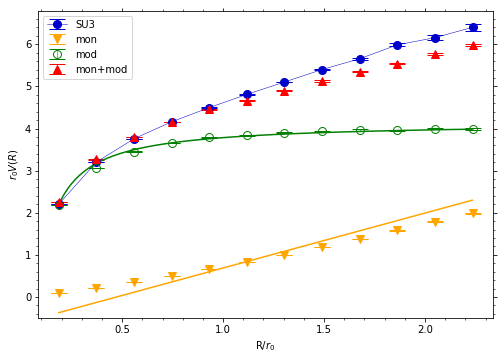

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_fit_original_24^4_beta6p0


In [132]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5}, 
        {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 'T' : 12}, 
        {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopoless.csv', 'T' : 8})
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition_fit_original_24^4_beta6p0', 
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'mod', 'mon', 'original')

aV(r)_SU3 3.351685769411084 0.00012412199370446034 -0.26697981016645067 1.3678151692816667e-05 1.5441017685001788 4.3141374498288086e-05 chi_sq = 0.00489797639410677
aV(r)_mon -0.1579358503892054 3.437712700373134e-05 0.01530550773484635 3.954903697408308e-06 0.8666627847573537 1.0936875840419606e-05 chi_sq = 0.010064540676045472
aV(r)_mod 3.920602247270892 0.0004773181769566901 -0.33094942436010233 6.755348737049365e-05 0.15023887054332533 6.634350560748651e-05 chi_sq = 0.002019043899628022
aV(r)_mon+mod 3.6969282050743857 0.00021049194332488954 -0.30641983651438187 2.928116062016922e-05 1.1042444131478755 3.188340503583331e-05 chi_sq = 0.0005397595244664785


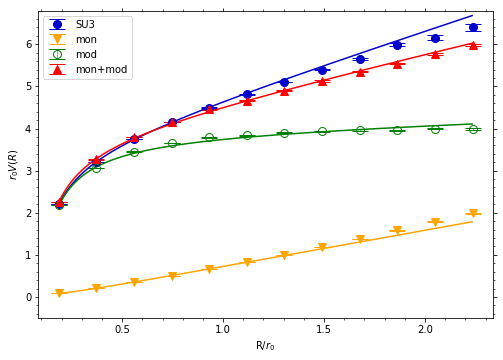

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_fit_separate_24^4_beta6p0


In [133]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5}, 
        {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 'T' : 12}, 
        {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopoless.csv', 'T' : 8})
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition_fit_separate_24^4_beta6p0', 
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'mod', 'mon', 'separate')

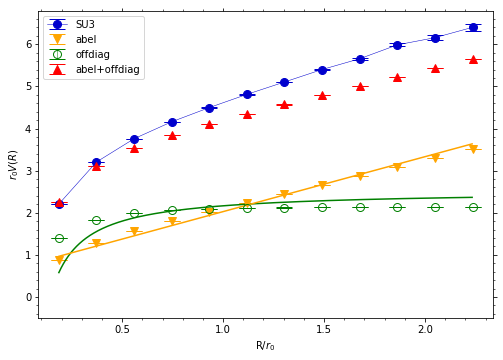

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition1_fit_original_24^4_beta6p0


In [90]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5}, 
        {'name' : 'abel', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 'T' : 6}, 
        {'name' : 'offdiag', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 'T' : 6})

potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition1_fit_original_24^4_beta6p0', 
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'offdiag', 'abel', 'original')

aV(r)_SU3 3.552685641944139 -0.3016897824447158 1.3581388283966227
aV(r)_abel 1.0768974596611114 -0.07731976165433495 1.0998777363568946
aV(r)_offdiag 2.318742597037845 -0.17084291315218458 -0.04788752476356491
aV(r)_abel+offdiag 3.3956400597143515 -0.24816267551126983 1.0519902099267406


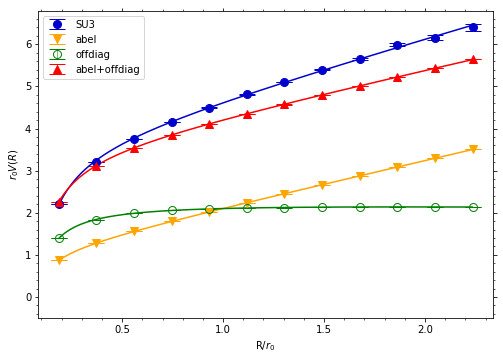

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition1_fit_separate_24^4_beta6p0


In [91]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5}, 
        {'name' : 'abel', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 'T' : 6}, 
        {'name' : 'offdiag', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 'T' : 6})

potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition1_fit_separate_24^4_beta6p0', 
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'offdiag', 'abel', 'separate')

aV(r)_SU2 3.0347388374724242 0.002183970371439487 -0.2690332303170666 0.0007995479870272999 0.9366393798255819 0.00012283323659484306
aV(r)_mon -0.179027397108819 0.00044926717254094024 0.029963120207228917 0.00016447598077301364 0.925752846249251 2.5268172429880344e-05
aV(r)_mod 3.0924948153432035 0.0002476351804628523 -0.2534110457946574 9.065889257183477e-05 -0.006828829174234006 1.3927767442504977e-05
aV(r)_mon+mod 2.9134674818018547 0.0008054079494946686 -0.22344793897007353 0.00029485853140306305 0.9189239803213761 4.529862969963038e-05


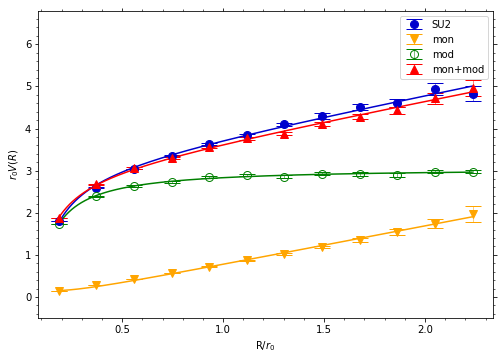

../../images/potential/decomposition/su2/su2_suzuki/24^4/beta5.5/potential_decomposition_24^4_beta2p5


In [112]:
path = '../../result/potential/wilson_loop/potential/su2/su2_suzuki/24^4/beta2.5'
paths = ({'name' : 'SU2', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5}, 
        {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_monopole.csv', 'T' : 12}, 
        {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_monopoless.csv', 'T' : 8})
potential_decomposition(paths, f'../../images/potential/decomposition/su2/su2_suzuki/24^4/beta2.5', 'potential_decomposition_24^4_beta2p5', 
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'mod', 'mon', 'separate')

aV(r)_SU2 3.0347388374724242 0.002183970371439487 -0.2690332303170666 0.0007995479870272999 0.9366393798255819 0.00012283323659484306
aV(r)_abel 1.3230001459487295 7.060550869100766e-05 -0.10459637004023804 2.58485606484126e-05 0.8963066403689619 3.97107201177143e-06
aV(r)_offdiag 1.442054330821383 4.510190606510708e-06 -0.09273189439773918 1.651173444438847e-06 -0.035803435297141556 2.5366704843904847e-07
aV(r)_abel+offdiag 2.7650544798462464 4.837597197751768e-05 -0.19732826521948502 1.7710364128099273e-05 0.8605032034273781 2.7208141260504138e-06


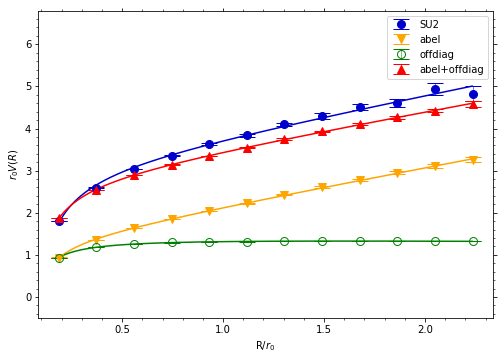

../../images/potential/decomposition/su2/su2_suzuki/24^4/beta2.5/potential_decomposition1_24^4_beta2p5


In [113]:
path = '../../result/potential/wilson_loop/potential/su2/su2_suzuki/24^4/beta2.5'
paths = ({'name' : 'SU2', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5}, 
        {'name' : 'abel', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_abelian.csv', 'T' : 6}, 
        {'name' : 'offdiag', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_offdiagonal.csv', 'T' : 6})
potential_decomposition(paths, f'../../images/potential/decomposition/su2/su2_suzuki/24^4/beta2.5', 'potential_decomposition1_24^4_beta2p5', 
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'mod', 'mon', 'separate')

In [ ]:
path = '../../result/potential/wilson_loop/potential/su2/su2_suzuki/24^4/beta2.5'
paths = ({'name' : 'SU2', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5}, 
        {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_monopole.csv', 'T' : 12}, 
        {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_monopoless.csv', 'T' : 8})
potential_decomposition(paths, f'../../images/potential/decomposition/su2/su2_suzuki/24^4/beta5.5', 'potential_decomposition_24^4_beta2p5', 
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'mod', 'mon', 'separate')

In [ ]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5}, 
        {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 'T' : 12}, 
        {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopoless.csv', 'T' : 8})
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition_24^4_beta6p0', 1, 6.0, 12)

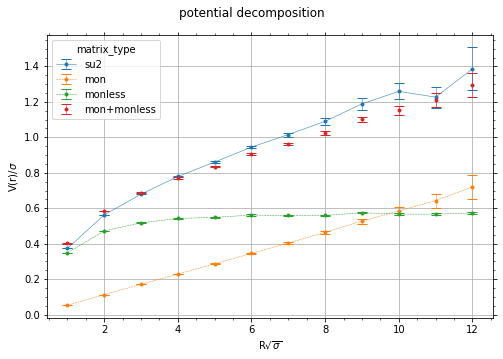

../images/potential/decomposition/qc2dstag/potential_qc2dstag_mu00


In [18]:
path = '../../result/smearing/potential/su2/su2_suzuki/24^4/beta2.4'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 4, 100), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/T_final=0.0001/OR_steps=6/potential_monopole.csv', 6, 80), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/T_final=0.0001/OR_steps=6/potential_monopoless.csv', 6, 80)}
potential_decomposition(paths, f'../images/potential/decomposition/qc2dstag', 'potential_qc2dstag_mu00', 1, 12)

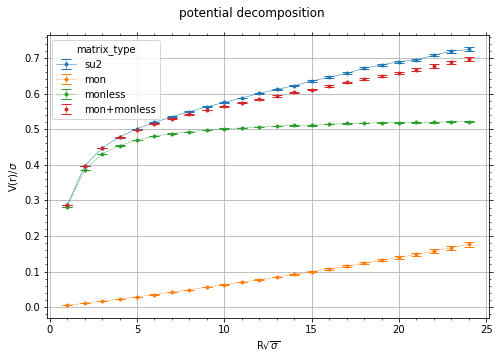

../images/potential/decomposition/su2_suzuki/potential_su2_suzuki_beta2p7


In [19]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.7'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6, 400), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0005/T_final=0.5/OR_steps=4/potential_monopole.csv', 16, 400), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0005/T_final=0.5/OR_steps=4/potential_monopoless.csv', 6, 400)}
potential_decomposition(paths, f'../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p7', 1, 24)

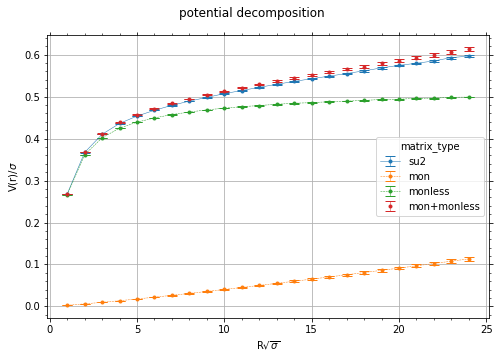

../../images/potential/decomposition/su2_suzuki/potential_su2_suzuki_beta2p8_0p001


In [20]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6, 400), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.001/T_final=0.5/OR_steps=4/potential_monopole.csv', 16, 300), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.001/T_final=0.5/OR_steps=4/potential_monopoless.csv', 6, 300)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_0p001', 1, 24)

/home/ilya/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2538: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/ilya/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2538: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


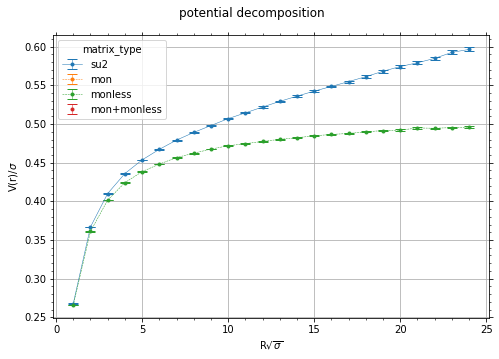

../../images/potential/decomposition/su2_suzuki/potential_su2_suzuki_beta2p8_0p0005


In [21]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6, 400), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0005/T_final=0.0005/OR_steps=4/potential_monopole.csv', 16, 30), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0005/T_final=0.0005/OR_steps=4/potential_monopoless.csv', 6, 300)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_0p0005', 1, 24)

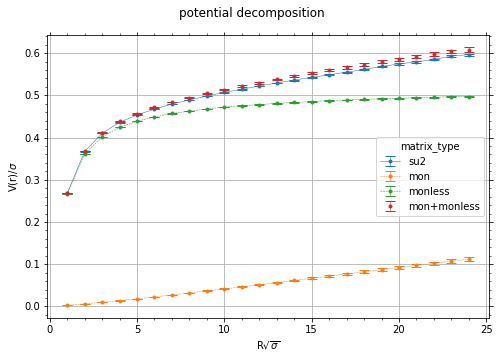

../../images/potential/decomposition/su2_suzuki/potential_su2_suzuki_beta2p8_0p0001


In [22]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6, 400), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/T_final=0.5/OR_steps=4/potential_monopole.csv', 16, 200), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/T_final=0.5/OR_steps=4/potential_monopoless.csv', 6, 300)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_0p0001', 1, 24)

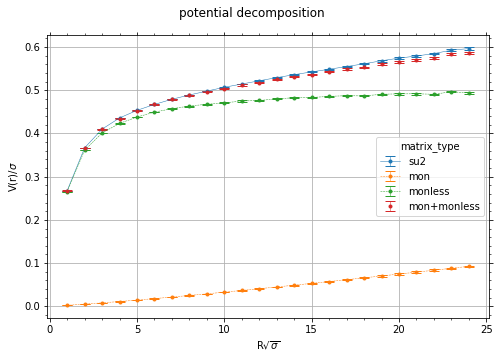

../../images/potential/decomposition/su2_suzuki/potential_su2_suzuki_beta2p8_5e-05


In [23]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6, 400), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=5e-05/T_final=0.5/OR_steps=4/potential_monopole.csv', 6, 400), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=5e-05/T_final=0.5/OR_steps=4/potential_monopoless.csv', 8, 400)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_5e-05', 1, 24)

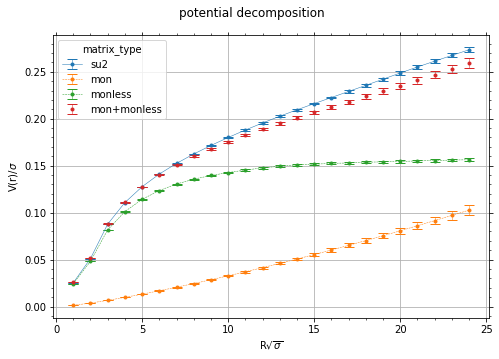

../../images/potential/decomposition/su2_suzuki/potential_su2_suzuki_beta2p8_5e-05


In [24]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 8, 360), 
        'mon': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/T_step=5e-05/T_final=0.5/OR_steps=4/potential_monopole.csv', 23, 400), 
        'monless': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/T_step=5e-05/T_final=0.5/OR_steps=4/potential_monopoless.csv', 16, 400)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_5e-05', 1, 24)

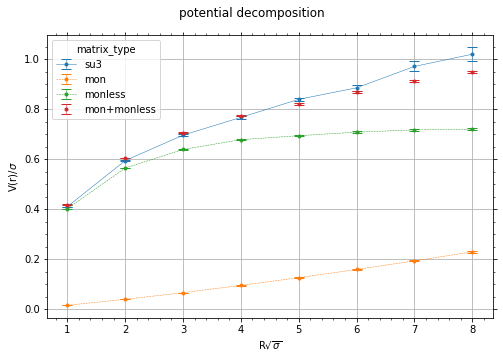

../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0/potential_decomposition_16^4_beta6p0


In [25]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 5, 600), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopole.csv', 5, 600), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopoless.csv', 5, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition_16^4_beta6p0', 1, 8)

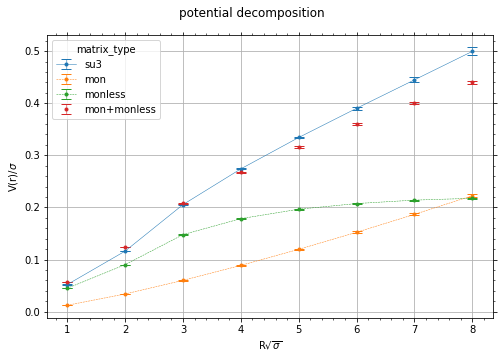

../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0/potential_decomposition_16^4_beta6p0


In [26]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'su3': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 5, 600), 
        'mon': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopole.csv', 5, 600), 
        'monless': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopoless.csv', 5, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition_16^4_beta6p0', 1, 8)

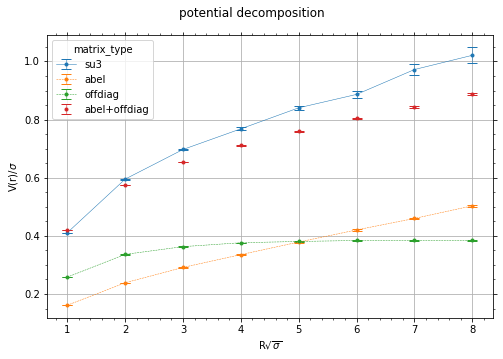

../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0/potential_decomposition1_16^4_beta6p0


In [27]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 5, 600), 
        'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_abelian.csv', 6, 600), 
        'offdiag': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_offdiagonal.csv', 6, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition1_16^4_beta6p0', 1, 8)

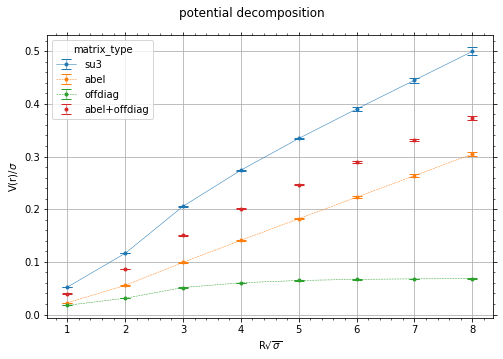

../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0/potential_decomposition1_16^4_beta6p0


In [28]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'su3': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 5, 600), 
        'abel': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_abelian.csv', 6, 600), 
        'offdiag': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_offdiagonal.csv', 6, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition1_16^4_beta6p0', 1, 8)

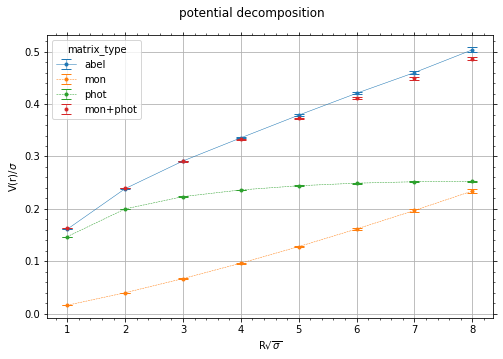

../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0/potential_decomposition2_16^4_beta6p0


In [29]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_abelian.csv', 6, 600), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopole.csv', 6, 600), 
        'phot': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_photon.csv', 6, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition2_16^4_beta6p0', 1, 8)

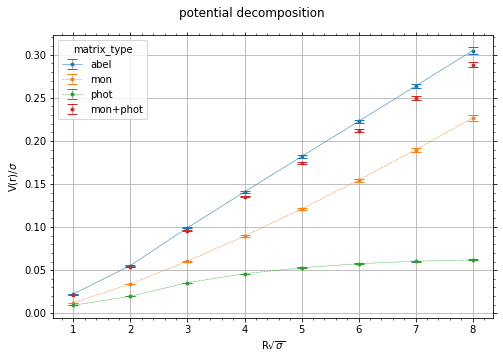

../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0/potential_decomposition2_16^4_beta6p0


In [30]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'abel': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_abelian.csv', 6, 600), 
        'mon': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopole.csv', 6, 600), 
        'phot': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_photon.csv', 6, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition2_16^4_beta6p0', 1, 8)

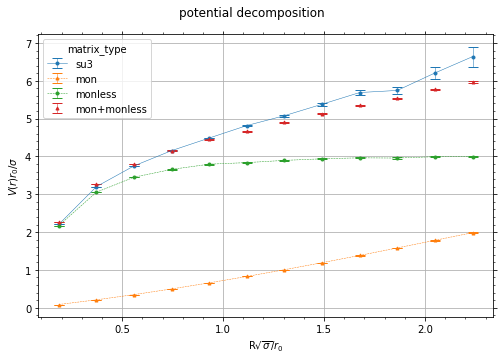

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_24^4_beta6p0


In [33]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 12), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopoless.csv', 8)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition_24^4_beta6p0', 1, 6.0, 12)

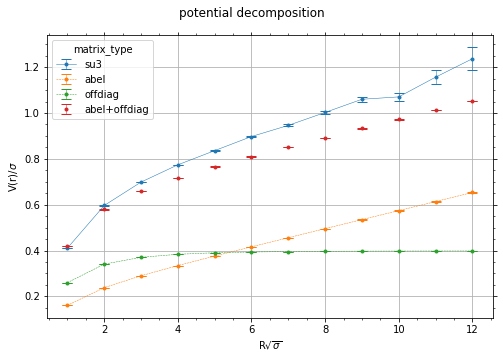

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition1_24^4_beta6p0


In [6]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6), 
        'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 6), 
        'offdiag': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 6)}

potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition1_24^4_beta6p0', 1, 12)

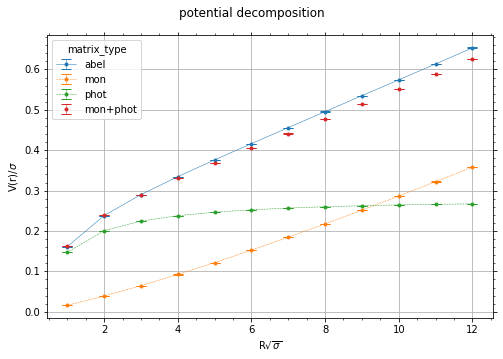

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition2_24^4_beta6p0


In [8]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = {'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 6), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 6), 
        'phot': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_photon.csv', 6)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition2_24^4_beta6p0', 1, 12)

su3_HYP0
su3_HYP1


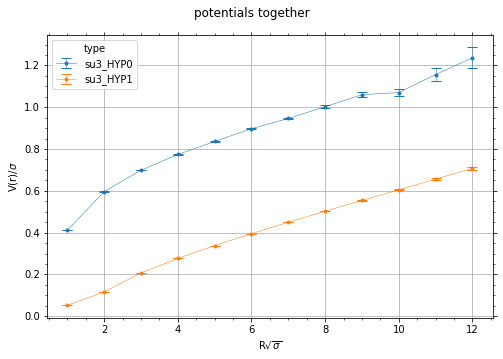

In [9]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = {'su3_HYP0': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6), 
         'su3_HYP1': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6)}
potentials_together(paths, 1, 12)

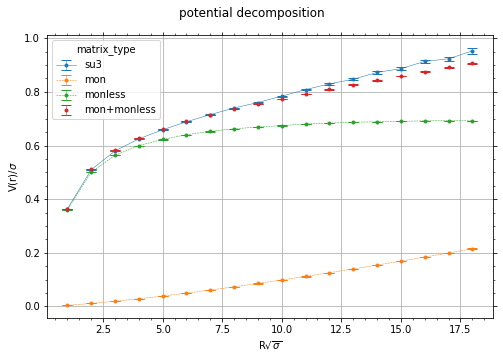

../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3/potential_decomposition_36^4_beta6p3


In [26]:
path = '../../result/potential/wilson_loop/potential/su3/gluodynamics/36^4/beta6.3'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 7), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 18), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopoless.csv', 7)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3', 'potential_decomposition_36^4_beta6p3', 1, 18)

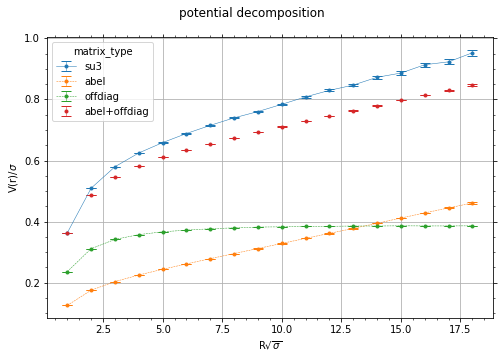

../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3/potential_decomposition1_36^4_beta6p3


In [27]:
path = '../../result/potential/wilson_loop/potential/su3/gluodynamics/36^4/beta6.3'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 7), 
        'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 12), 
        'offdiag': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 12)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3', 'potential_decomposition1_36^4_beta6p3', 1, 18)

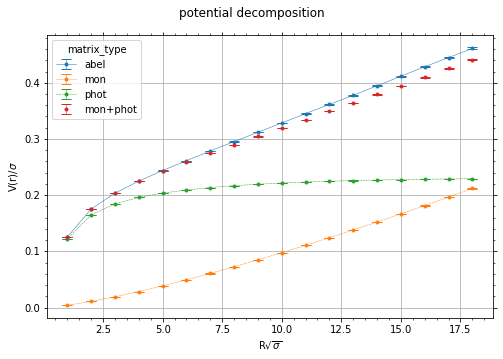

../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3/potential_decomposition2_36^4_beta6p3


In [28]:
path = '../../result/potential/wilson_loop/potential/su3/gluodynamics/36^4/beta6.3'
paths = {'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 12), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 12), 
        'phot': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_photon.csv', 12)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3', 'potential_decomposition2_36^4_beta6p3', 1, 18)

In [201]:
def plot_time_dependence(path, space_size, T_max, image_path, image_name):
    df_data = pd.read_csv(path, index_col=None)
    
    df_data = df_data[df_data['r/a'] == space_size]
    df_data = df_data[df_data['T'] <= T_max]
    fg = seaborn.FacetGrid(data=df_data, height=3.5, aspect=1.61)
    fg.fig.suptitle(f'r={space_size}')
    fg.map(plt.errorbar, 'T', 'aV(r)', 'err', marker="o", fmt='', linestyle = '').add_legend()
    
    plt.show()

    save_image(image_path, image_name, fg)
    
def plot_time_dependence_space(mu, monopole, smearing, lattice_size):
    df_data_40_5 = pd.read_csv(f"../result/potential_spatial/{monopole}/qc2dstag/{lattice_size}/potential_spatial_mu=0.{mu}.csv", index_col=None)
    
    time_sizes = [6, 8, 10, 12, 14, 16, 18, 20]
    
    df1 = df_data_40_5[df_data_40_5['T'].isin(time_sizes)]
    fg = seaborn.FacetGrid(data=df1, hue='T',  aspect=1.61)
    fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', marker="o", fmt='', linestyle = '').add_legend()
    
    image_path = f'../images/potential_spatial/qc2dstag/{lattice_size}'
    try:
        os.makedirs(image_path)
    except:
        pass
    
    image_path = f'{image_path}/potential_space_{monopole}_mu=0p{mu}_time_dependence'
    fg.savefig(image_path)

In [202]:
def make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate):
    print('original')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/potential/{common_path}/potential_original.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}'
        image_name = f'potential_time_original_r={r}'
        plot_time_dependence(path, r, T_max_arr[0], image_path, image_name)
    print('monopole')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/potential/{common_path}/{additional_parameters}/{compensate}/potential_monopole.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}/{additional_parameters}'
        image_name = f'potential_time_monopole_r={r}'
        plot_time_dependence(path, r, T_max_arr[1], image_path, image_name)
    print('monopoless')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/potential/{common_path}/{additional_parameters}/{compensate}/potential_monopoless.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}/{additional_parameters}'
        image_name = f'potential_time_monopoless_r={r}'
        plot_time_dependence(path, r, T_max_arr[2], image_path, image_name)
    print('abelian')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/potential/{common_path}/{additional_parameters}/potential_abelian.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}'
        image_name = f'potential_time_abelian_r={r}'
        plot_time_dependence(path, r, T_max_arr[3], image_path, image_name)
    print('offdiagonal')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/potential/{common_path}/{additional_parameters}/{compensate}/potential_offdiagonal.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}/{additional_parameters}'
        image_name = f'potential_time_offdiagonal_r={r}'
        plot_time_dependence(path, r, T_max_arr[4], image_path, image_name)
    print('photon')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/potential/{common_path}/{additional_parameters}/{compensate}/potential_photon.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}/{additional_parameters}'
        image_name = f'potential_time_photon_r={r}'
        plot_time_dependence(path, r, T_max_arr[5], image_path, image_name)

In [200]:
common_path = 'su3/gluodynamics/36^4/beta6.3/HYP0_alpha=1_1_0.5_APE_alpha=0.5'
T_max_arr = [10, 18, 12, 18, 18, 18]
space_sizes = [2, 4, 8, 12, 16, 20, 24, 30, 36]
compensate = 'compensate_1'
additional_parameters = 'steps_500/copies=3'
make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate)

original
r = 2


NameError: name 'plot_time_dependence' is not defined

original
r = 2


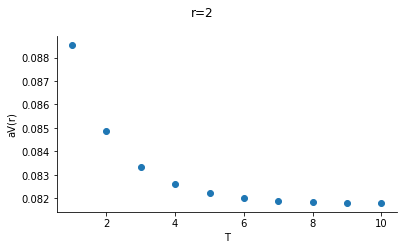

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=2
r = 4


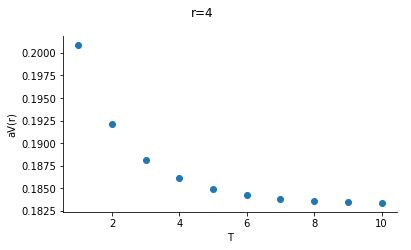

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=4
r = 8


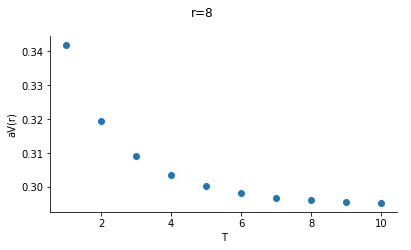

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=8
r = 12


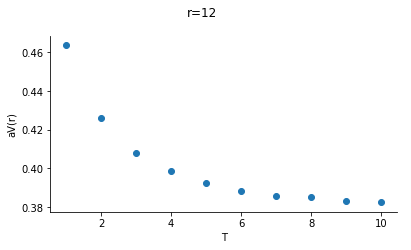

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=12
r = 16


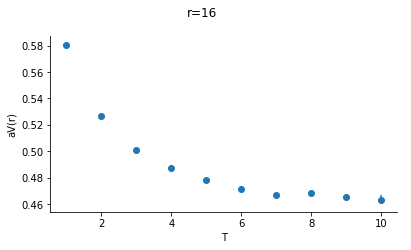

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=16
r = 20


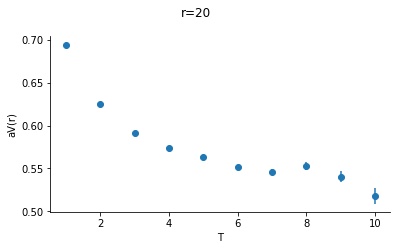

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=20
r = 24


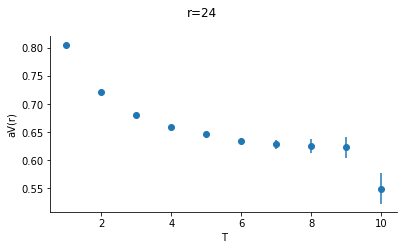

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=24
r = 30


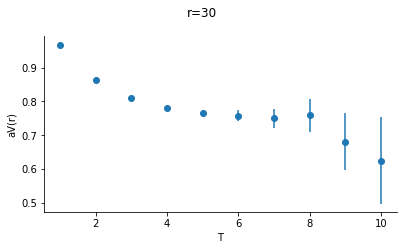

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=30
r = 36


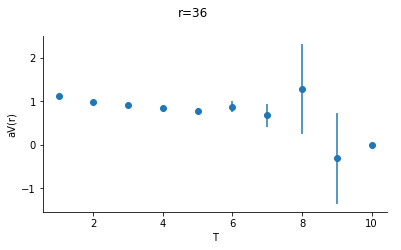

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=36
monopole
r = 2


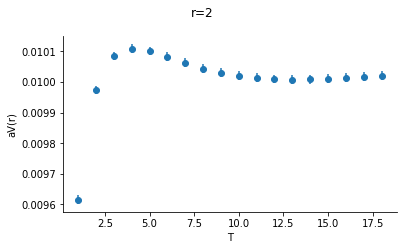

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=2
r = 4


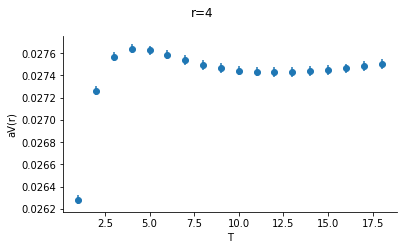

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=4
r = 8


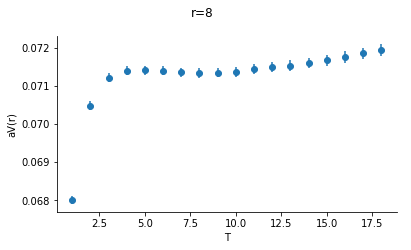

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=8
r = 12


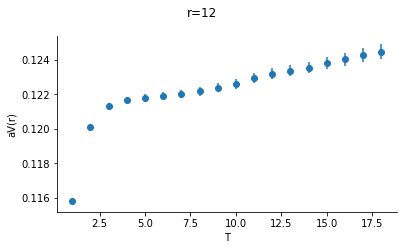

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=12
r = 16


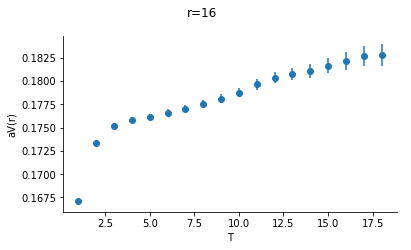

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=16
r = 20


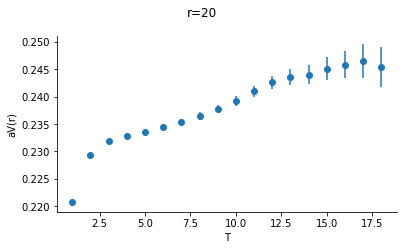

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=20
r = 24


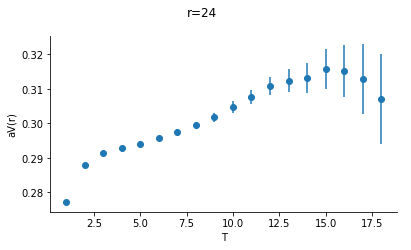

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=24
r = 30


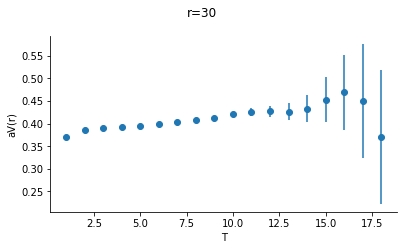

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=30
r = 36


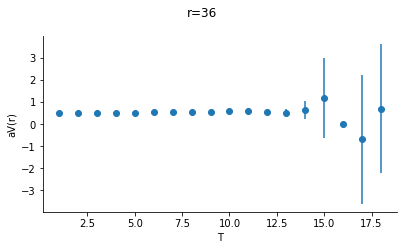

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=36
monopoless
r = 2


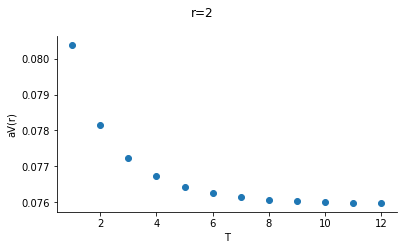

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=2
r = 4


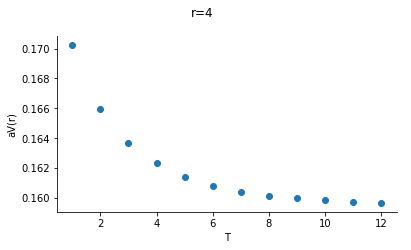

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=4
r = 8


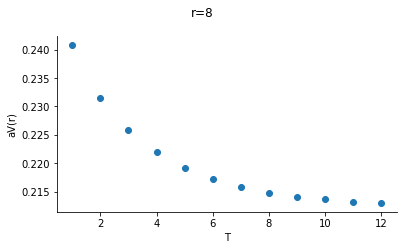

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=8
r = 12


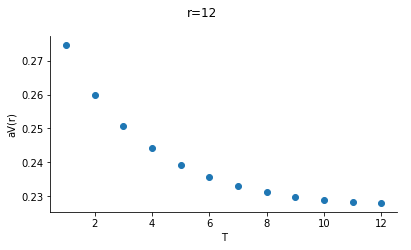

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=12
r = 16


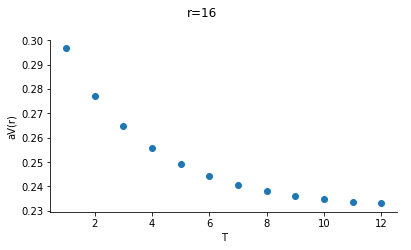

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=16
r = 20


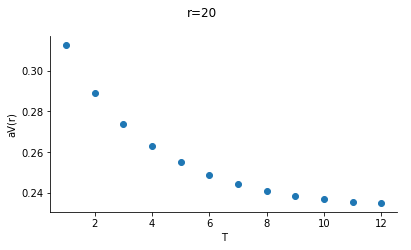

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=20
r = 24


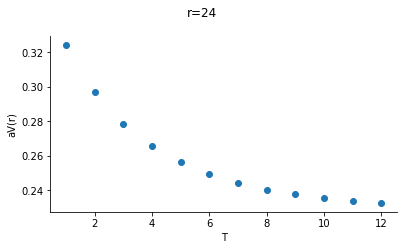

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=24
r = 30


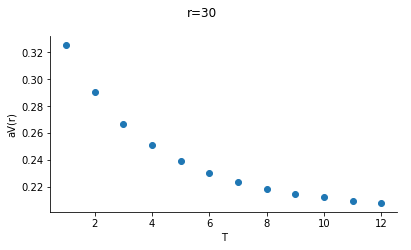

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=30
r = 36


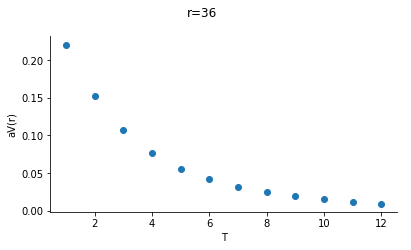

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=36
abelian
r = 2


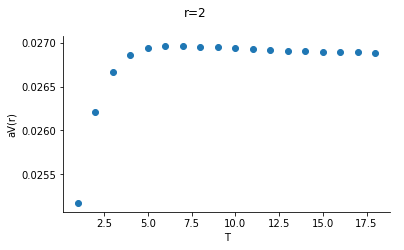

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=2
r = 4


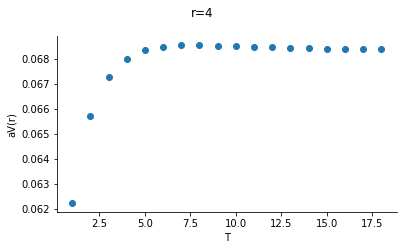

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=4
r = 8


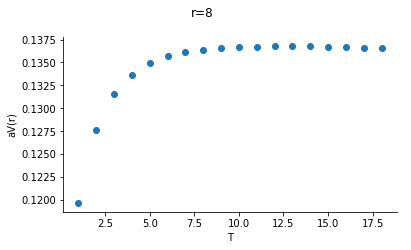

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=8
r = 12


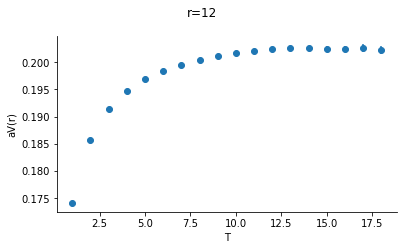

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=12
r = 16


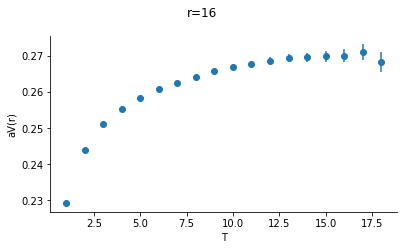

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=16
r = 20


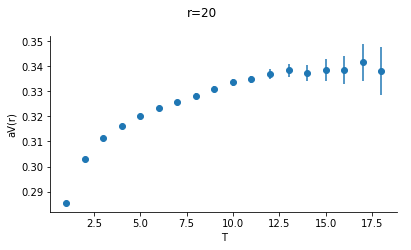

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=20
r = 24


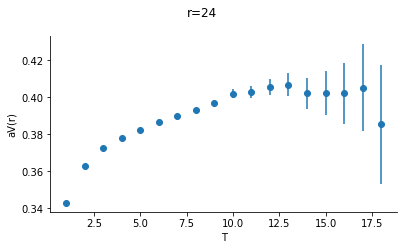

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=24
r = 30


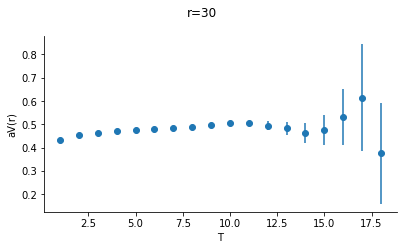

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=30
r = 36


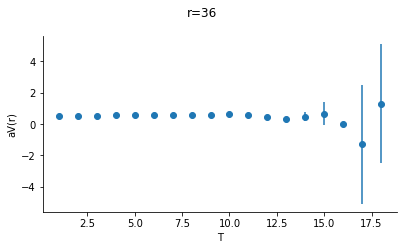

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=36
offdiagonal
r = 2


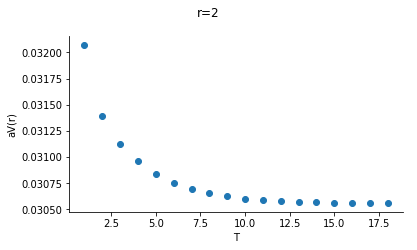

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=2
r = 4


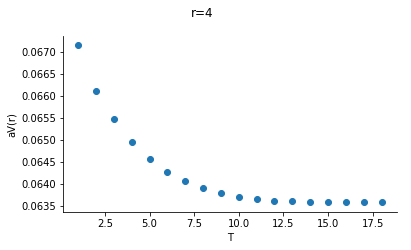

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=4
r = 8


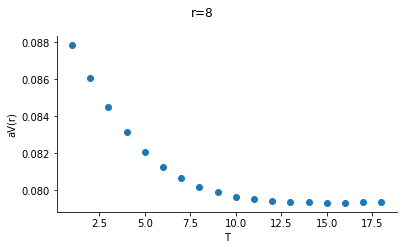

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=8
r = 12


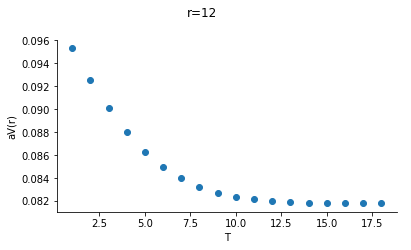

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=12
r = 16


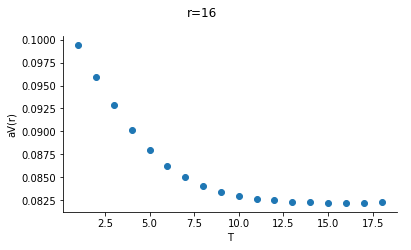

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=16
r = 20


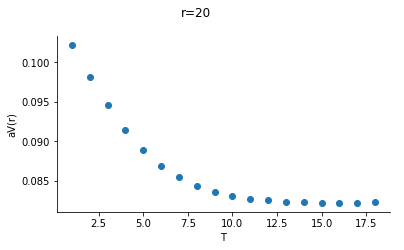

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=20
r = 24


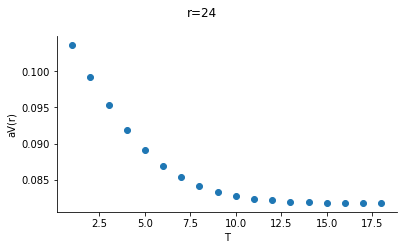

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=24
r = 30


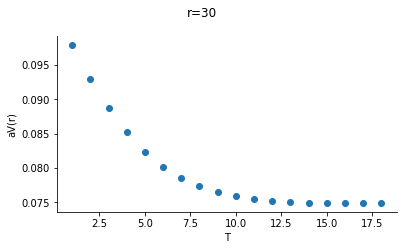

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=30
r = 36


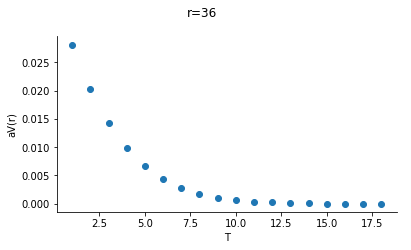

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=36
photon
r = 2


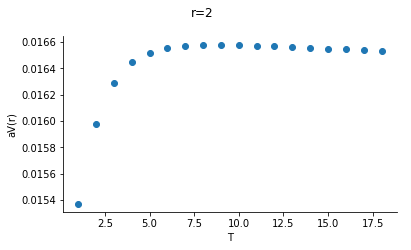

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=2
r = 4


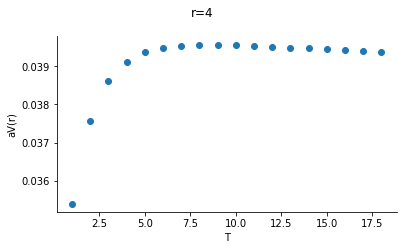

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=4
r = 8


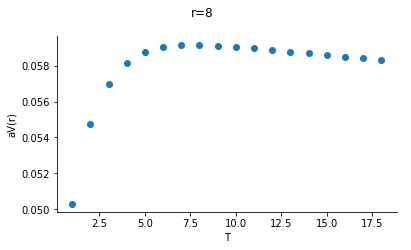

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=8
r = 12


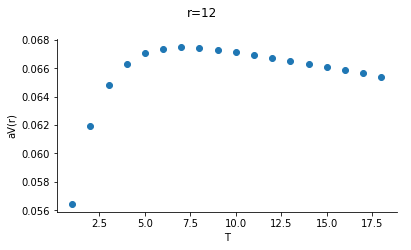

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=12
r = 16


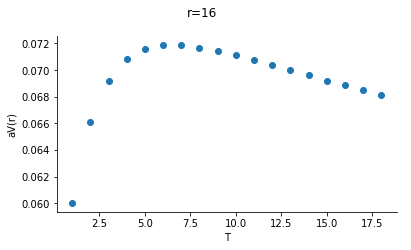

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=16
r = 20


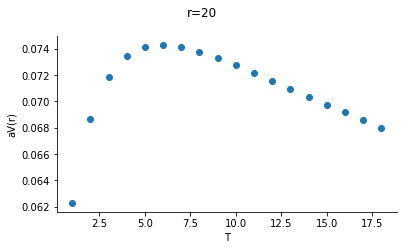

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=20
r = 24


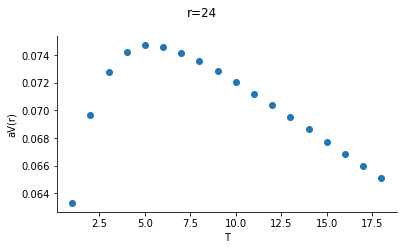

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=24
r = 30


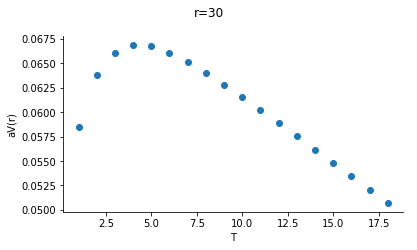

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=30
r = 36


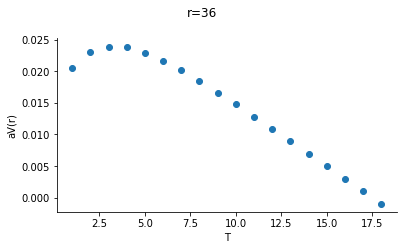

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=36


In [36]:
common_path = 'su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5'
T_max_arr = [10, 18, 12, 18, 18, 18]
space_sizes = [2, 4, 8, 12, 16, 20, 24, 30, 36]
compensate = 'compensate_1'
additional_parameters = 'steps_500/copies=3'
make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate)

original
r = 2


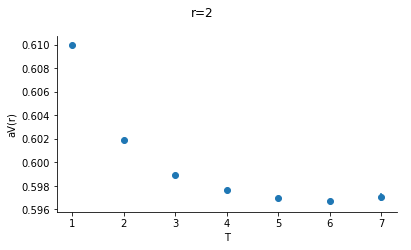

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=2
r = 4


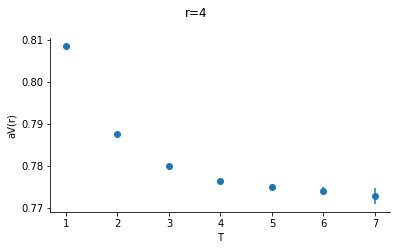

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=4
r = 8


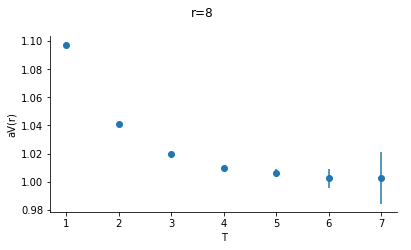

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=8
r = 10


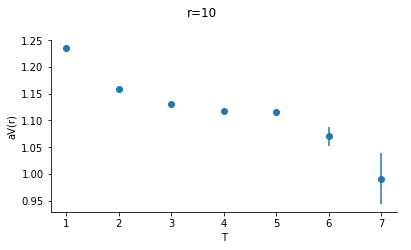

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=10
r = 11


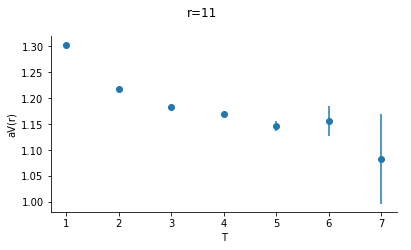

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=11
r = 12


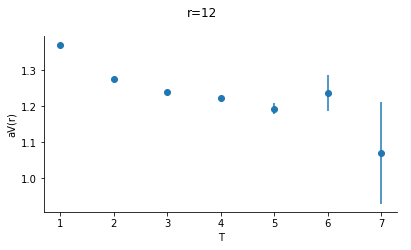

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=12
monopole
r = 2


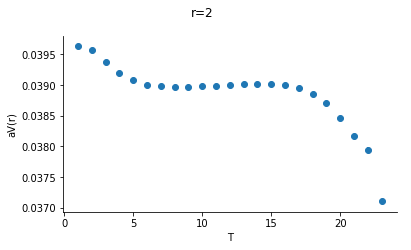

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=2
r = 4


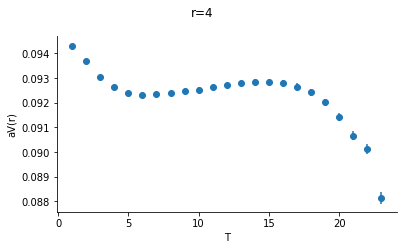

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=4
r = 8


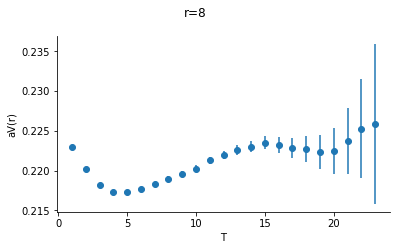

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=8
r = 10


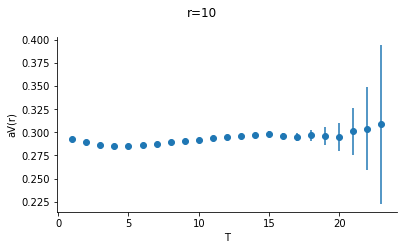

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=10
r = 11


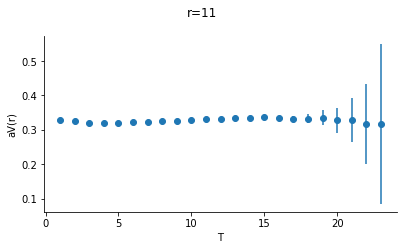

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=11
r = 12


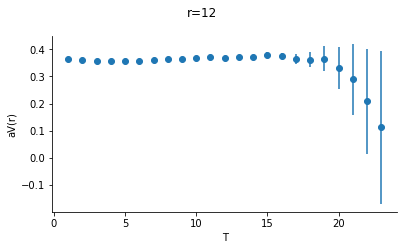

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=12
monopoless
r = 2


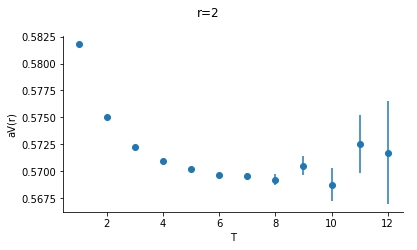

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=2
r = 4


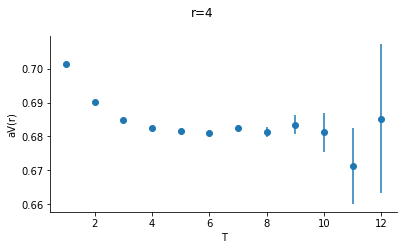

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=4
r = 8


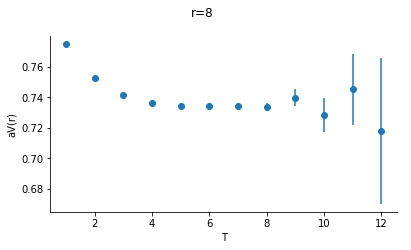

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=8
r = 10


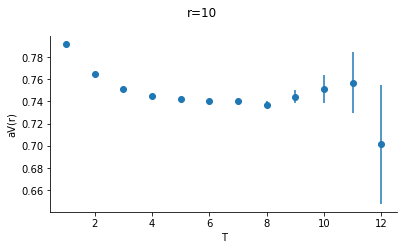

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=10
r = 11


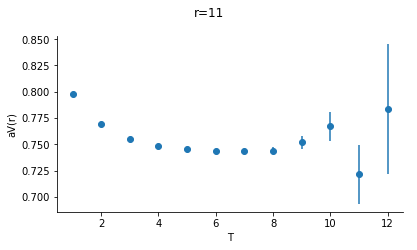

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=11
r = 12


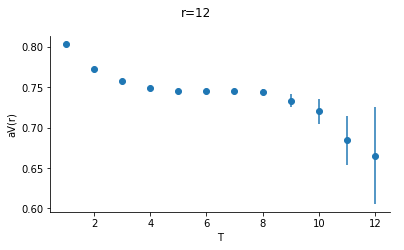

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=12
abelian
r = 2


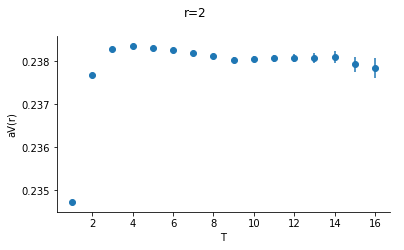

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=2
r = 4


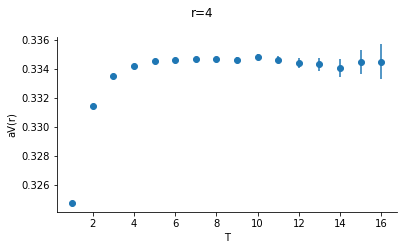

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=4
r = 8


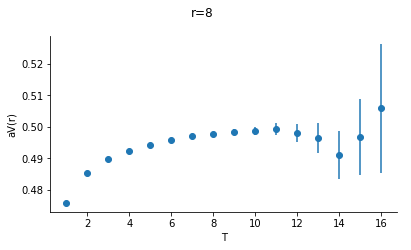

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=8
r = 10


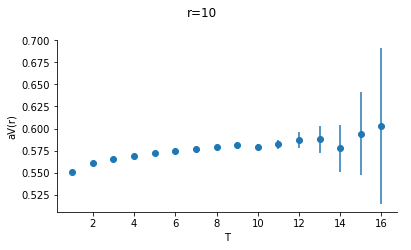

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=10
r = 11


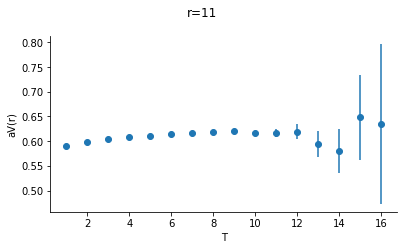

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=11
r = 12


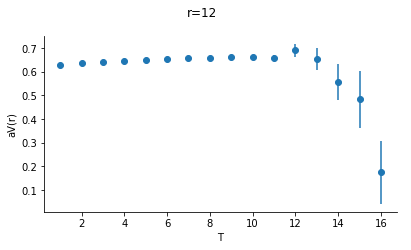

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=12
offdiagonal
r = 2


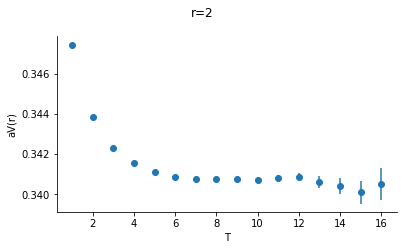

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=2
r = 4


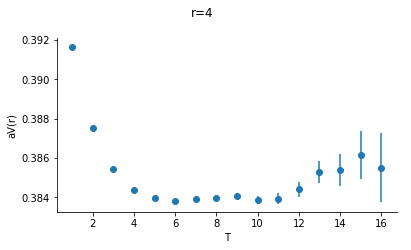

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=4
r = 8


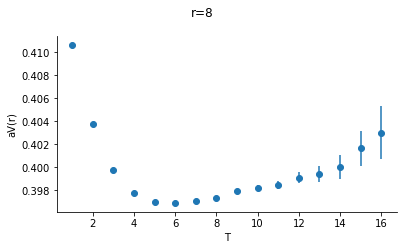

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=8
r = 10


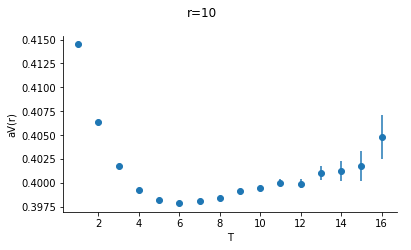

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=10
r = 11


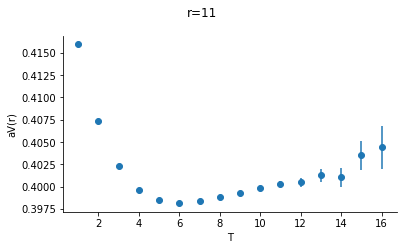

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=11
r = 12


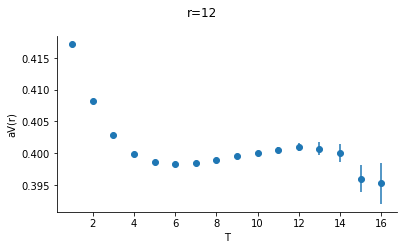

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=12
photon
r = 2


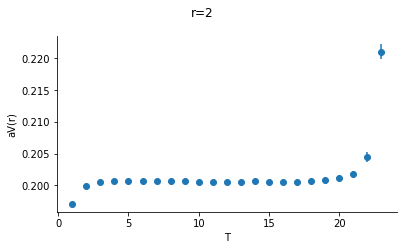

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=2
r = 4


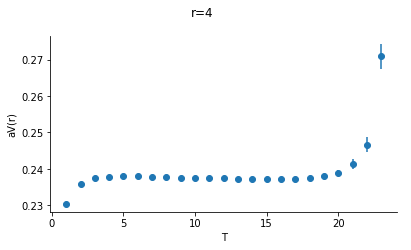

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=4
r = 8


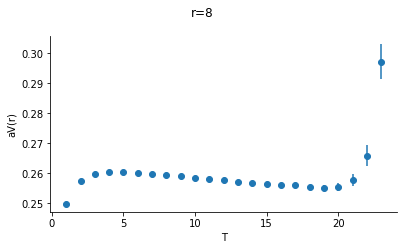

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=8
r = 10


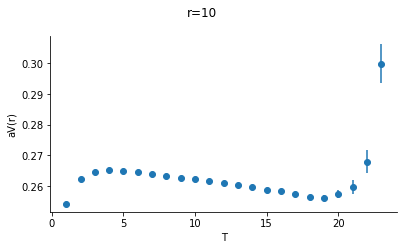

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=10
r = 11


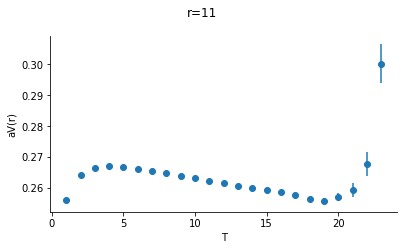

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=11
r = 12


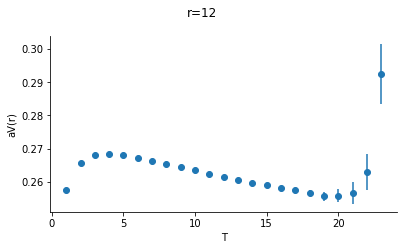

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=12


In [203]:
common_path = 'su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5'
T_max_arr = [7, 24, 12, 16, 16, 24]
space_sizes = [2, 4, 8, 10, 11, 12]
compensate = 'compensate_1'
additional_parameters = 'steps_500/copies=3'
make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate)

original
r = 2


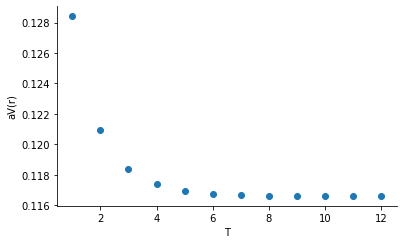

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=2
r = 4


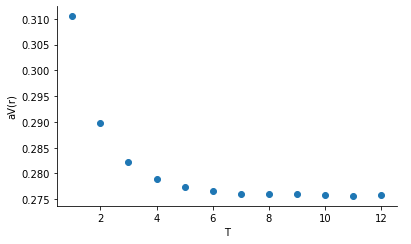

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=4
r = 8


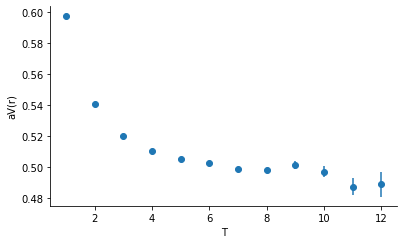

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=8
r = 12


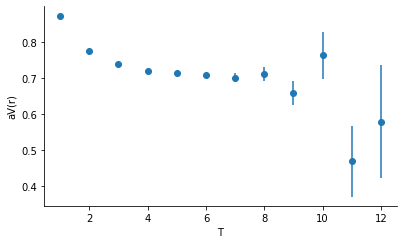

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=12
r = 16


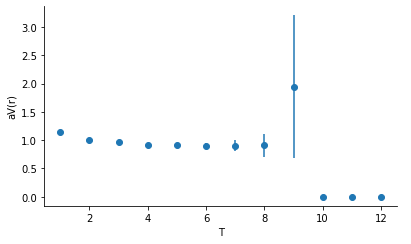

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=16
r = 20


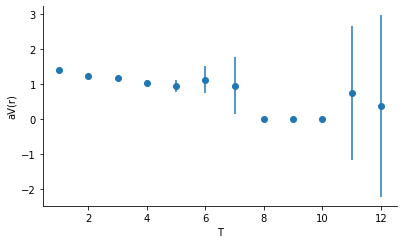

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=20
r = 24


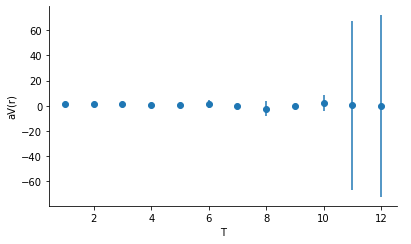

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_original_r=24
monopole
r = 2


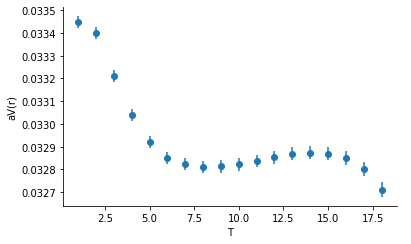

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=2
r = 4


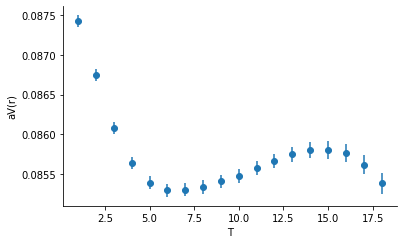

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=4
r = 8


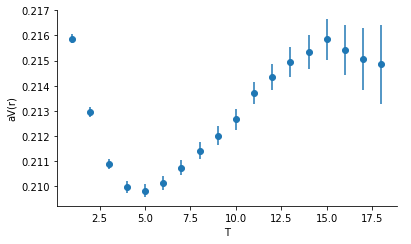

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=8
r = 12


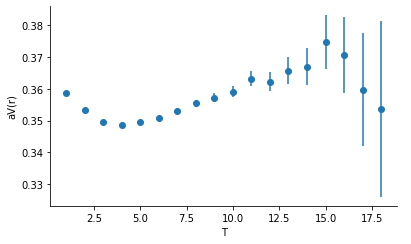

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=12
r = 16


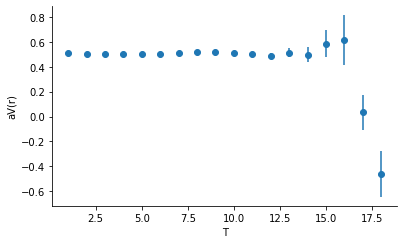

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=16
r = 20


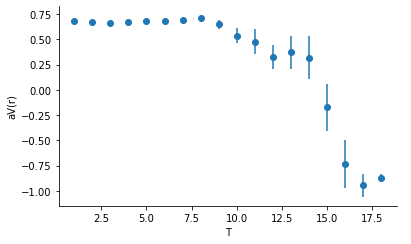

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=20
r = 24


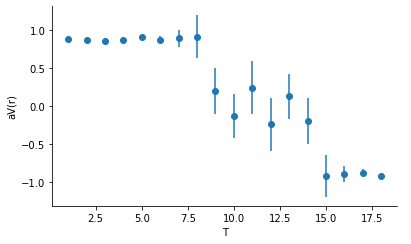

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopole_r=24
monopoless
r = 2


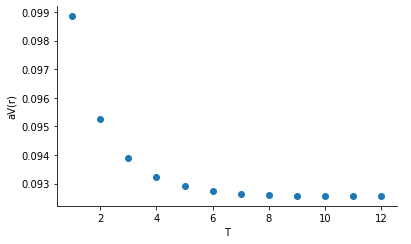

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=2
r = 4


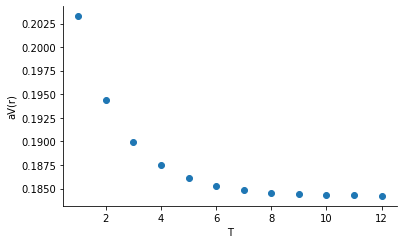

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=4
r = 8


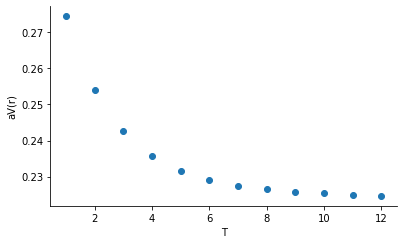

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=8
r = 12


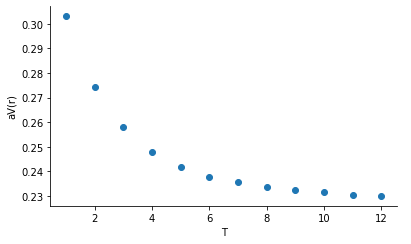

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=12
r = 16


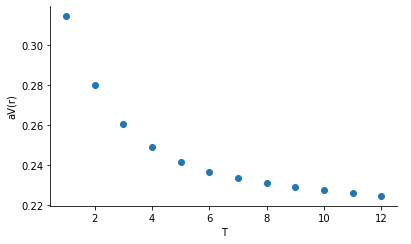

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=16
r = 20


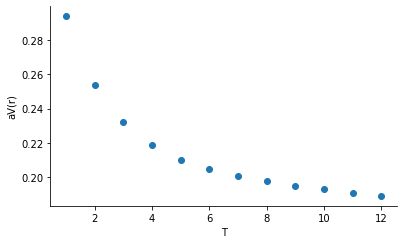

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=20
r = 24


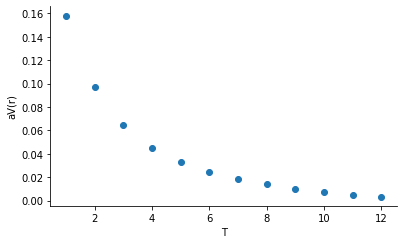

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_monopoless_r=24
abelian
r = 2


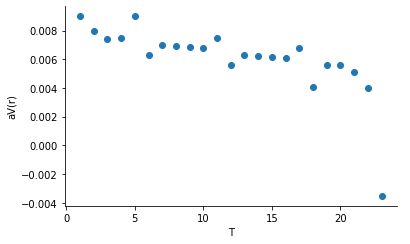

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=2
r = 4


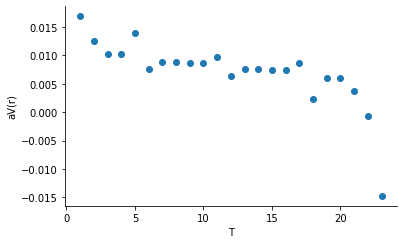

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=4
r = 8


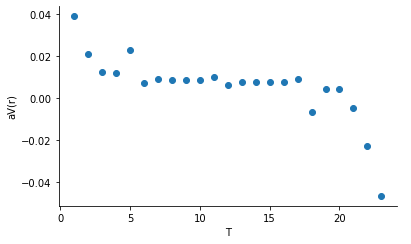

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=8
r = 12


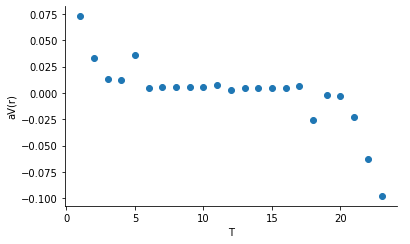

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=12
r = 16


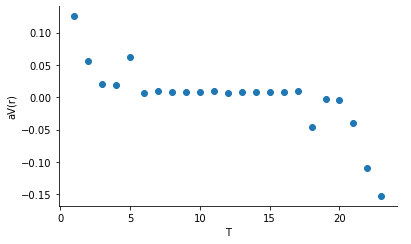

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=16
r = 20


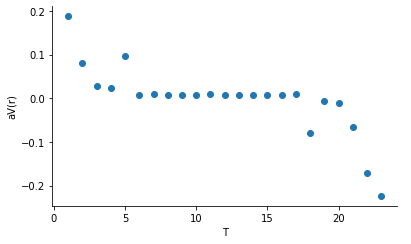

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=20
r = 24


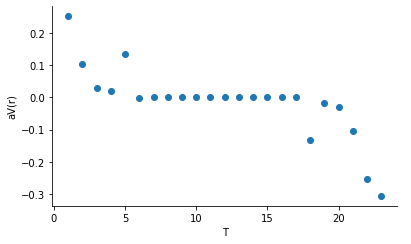

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_time_abelian_r=24
offdiagonal
r = 2


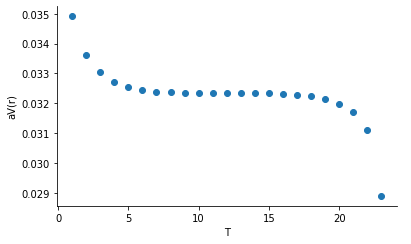

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=2
r = 4


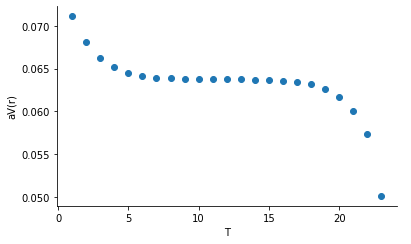

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=4
r = 8


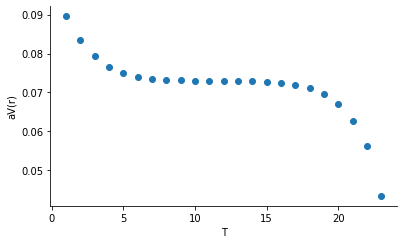

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=8
r = 12


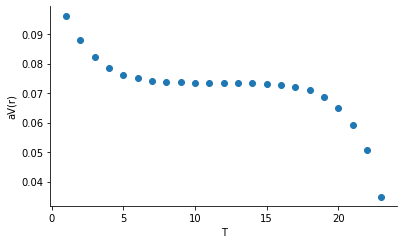

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=12
r = 16


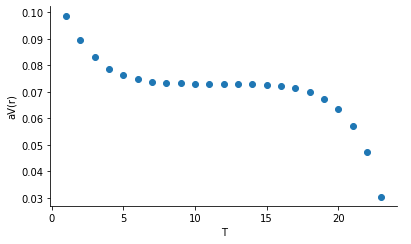

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=16
r = 20


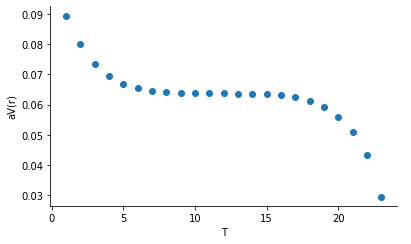

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=20
r = 24


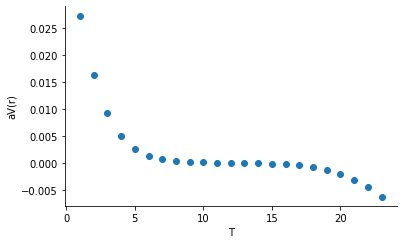

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_offdiagonal_r=24
photon
r = 2


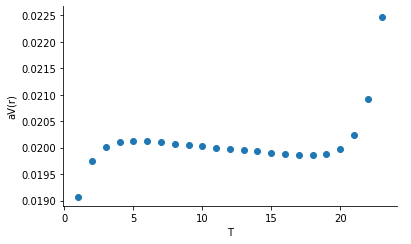

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=2
r = 4


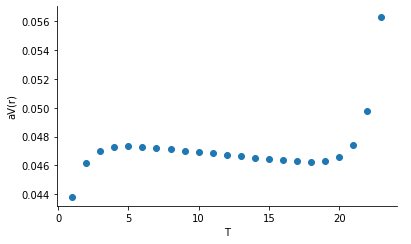

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=4
r = 8


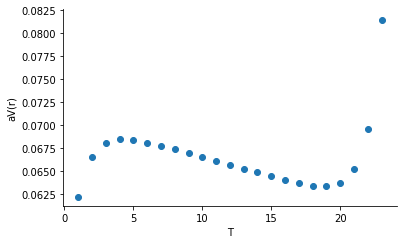

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=8
r = 12


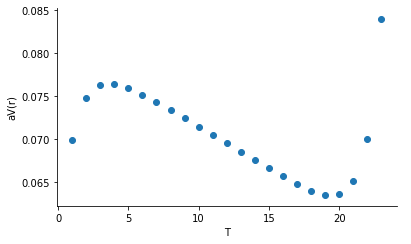

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=12
r = 16


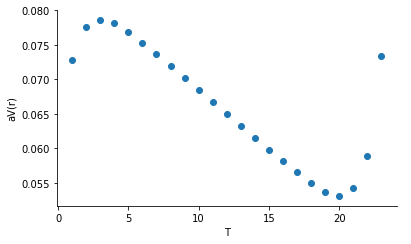

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=16
r = 20


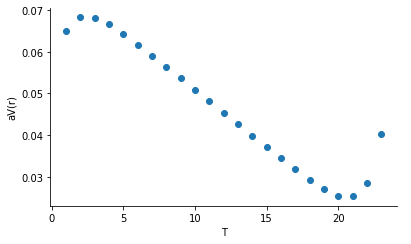

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=20
r = 24


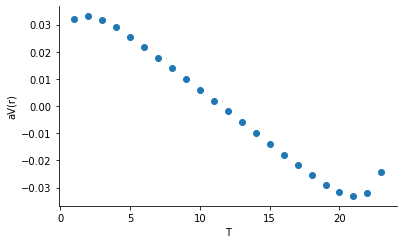

../../images/potential/fundamental/wilson_loop/time_dependence/su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_time_photon_r=24


In [15]:
common_path = 'su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5'
T_max_arr = [12, 18, 12, 24, 24, 24]
space_sizes = [2, 4, 8, 12, 16, 20, 24]
compensate = 'compensate_1'
additional_parameters = 'steps_500/copies=3'
make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate)

In [ ]:
plot_time_dependence('05', 'monopole', '40^4', 'smeared')
plot_time_dependence('35', 'monopole', '40^4')
plot_time_dependence('45', 'monopole', '40^4')

In [ ]:
plot_time_dependence('05', 'monopoless', '40^4')
plot_time_dependence('35', 'monopoless', '40^4')
plot_time_dependence('45', 'monopoless', '40^4')

In [ ]:
plot_time_dependence('05', '', '40^4', 'smeared')
plot_time_dependence('35', '', '40^4', 'smeared')
plot_time_dependence('45', '', '40^4', 'smeared')

In [ ]:
plot_time_dependence('05', '', '40^4', 'unsmeared')

In [ ]:
plot_time_dependence('00', 'monopole', '32^4', 'unsmeared')
plot_time_dependence('00', 'monopoless', '32^4', 'smeared')
plot_time_dependence('00', '', '32^4', 'smeared')

In [ ]:
plot_time_dependence('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', '')
plot_time_dependence('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', '1')
plot_time_dependence('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', '2')

In [ ]:
plot_time_dependence_space('05', '', '', '40^4')

In [4]:
def plot_time_dependence_several_sizes(mu, monopole, lattice_size, smearing, space_sizes, statistics_type):
    df_data = pd.read_csv(f"../result/potential/on-axis/{monopole}/qc2dstag/{smearing}/{lattice_size}/potential_mu=0.{mu}.csv", index_col=None)
    
#     time_sizes = [6, 8, 10, 12, 14, 16, 18, 20]
#     space_sizes = [1, 2, 3]
    
    df1 = df_data[df_data['r/a'].isin(space_sizes)]
    df1 = df1[df1['T'] <= 16]
    fg = seaborn.FacetGrid(data=df1, hue='r/a',  aspect=1.61)
    fg.map(plt.errorbar, 'T', f'aV{statistics_type}(r)', f'err{statistics_type}', marker="o", fmt='', linestyle = '').add_legend()
    
    image_path = f'../images/potential/on-axis/qc2dstag/{smearing}/{lattice_size}'
    try:
        os.makedirs(image_path)
    except:
        pass
    
    image_path = f'{image_path}/potential_{monopole}_mu=0p{mu}_time_dependence'
    fg.savefig(image_path)

In [ ]:
space_sizes = [[1], [6], [10], [14], [18]]
for space_size in space_sizes:
    plot_time_dependence_several_sizes('05', '', '40^4', 'smeared', space_size, '')

In [ ]:
space_sizes = [[1], [2], [3], [4], [6], [10], [14], [16]]
for space_size in space_sizes:
    plot_time_dependence_several_sizes('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', space_size, '')

In [ ]:
space_sizes = [[1], [2], [3], [4], [6], [10], [14], [16]]
for space_size in space_sizes:
    plot_time_dependence_several_sizes('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', space_size, '1')

In [ ]:
space_sizes = [[1], [2], [3], [4], [6], [10], [14], [16]]
for space_size in space_sizes:
    plot_time_dependence_several_sizes('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', space_size, '2')

In [5]:
from scipy.optimize import curve_fit

def make_potential_trunin(data, df1, df, time_size_max):
   
    time_size = data["T"].iloc[0]
    space_size = data["r/a"].iloc[0]

    if time_size < time_size_max:

        wilson_loop_T = df[(df['T'] == time_size) & (df['r/a'] == space_size)]['wilson_loop'].values[0]
        wilson_loop_T1 = df[(df['T'] == time_size + 1) & (df['r/a'] == space_size)]['wilson_loop'].values[0]

        wilson_loop_err_T = df[(df['T'] == time_size) & (df['r/a'] == space_size)]['wilson_loop_err'].values[0]
        wilson_loop_err_T1 = df[(df['T'] == time_size + 1) & (df['r/a'] == space_size)]['wilson_loop_err'].values[0]

        try:
            new_row = {'aV(r)': math.log(wilson_loop_T/wilson_loop_T1), 'err': math.sqrt(wilson_loop_err_T ** 2 / wilson_loop_T1 ** 2 + wilson_loop_err_T1 ** 2 * wilson_loop_T ** 2 / wilson_loop_T1 ** 4)}

            df1 = df1.append(new_row, ignore_index=True)

            return df1
        except ValueError:
            return df1

def plots_T(data, fit_start, fit_end, procedure, T_lim):

    x = data[(data['T'] >= fit_start) & (data['T'] <= fit_end)]['T'].to_numpy()
    y = data[(data['T'] >= fit_start) & (data['T'] <= fit_end)]['aV(r)'].to_numpy()

    fg = seaborn.FacetGrid(data=data, height=5, aspect=1.2)
    fg.map(plt.errorbar, 'T', 'aV(r)', 'err', marker="o", fmt='', linestyle = '')

    if procedure == 'fitting':
        popt, pcov = curve_fit(func_exponent, x, y)

        x1 = np.arange(x.min(), x.max(), 0.01)
        y1 = func_exponent(x1, popt[0], popt[1], popt[2])

        plt.plot(x1, y1)

    plt.show()

    if procedure == 'fitting':
        return pd.Series([popt[0], math.sqrt(pcov[0][0])], index=['aV(r)', 'err'])
    elif procedure == 'limit':
        return pd.Series([data[data['T'] == T_lim]['aV(r)'].iloc[0], data[data['T'] == T_lim]['err'].iloc[0]], index=['aV(r)', 'err'])


def func_exponent(x, a, b, c):
    return a + b * np.exp(-x * c)

def func_linear_potential(x, c, alpha, sigma):
    return c + alpha * np.power(x, -1) + sigma * x

def func_coulomb(x, c, alpha, mu):
    return c + alpha * np.exp(-mu * x) * np.power(x, -1)
    

In [96]:
def get_string_tension(path, fit_start, fit_end, procedure):    

    data = pd.read_csv(path, header=0, names=['r/a', "T", "wilson_loop", "wilson_loop_err"], delim_whitespace=True)

    time_size_max = data["T"].max()

    df1 = pd.DataFrame(columns=["aV(r)", "err"])

    df1 = data.groupby(['T', 'r/a']).apply(make_potential_trunin, df1, data, time_size_max).reset_index()

    print("fitting")

    df = df1.groupby(['r/a']).apply(plots_T, 2, 10, procedure, 10).reset_index()

    x = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['r/a'].to_numpy()
    y = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['aV(r)'].to_numpy()

    popt, pcov = curve_fit(func_linear_potential, x, y) 

    print(popt[0], popt[1], popt[2])

    fg = seaborn.FacetGrid(data=df, height=5, aspect=1.2)
    fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', marker="o", fmt='', linestyle = '')

    x1 = np.arange(x.min(), x.max(), 0.01)
    y1 = func_linear_potential(x1, popt[0], popt[1], popt[2])

    plt.plot(x1, y1)

    plt.show()

    return popt[2], math.sqrt(pcov[2][2])

def get_string_tension_test(path, fit_start, fit_end):

    df_common = []

    data = pd.read_csv(path, header=0, names=['r/a', "T", "wilson_loop", "wilson_loop_err"], delim_whitespace=True)

    time_size_max = data["T"].max()

    df1 = pd.DataFrame(columns=["aV(r)", "err"])

    df1 = data.groupby(['T', 'r/a']).apply(make_potential_trunin, df1, data, time_size_max).reset_index()

    df = df1.groupby(['r/a']).apply(plots_T, 2, 10, 'fitting', 8).reset_index()

    df_common.append(df)
    df_common[-1]['procedure'] = 'fitting'

    x = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['r/a'].to_numpy()
    y = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['aV(r)'].to_numpy()

    popt, pcov = curve_fit(func_linear_potential, x, y) 

    print(popt[0], popt[1], popt[2])

    # fg = seaborn.FacetGrid(data=df, height=5, aspect=1.2)
    # fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', marker="o", fmt='', linestyle = '')

    x1 = np.arange(x.min(), x.max(), 0.01)
    y1 = func_linear_potential(x1, popt[0], popt[1], popt[2])

    df = df1.groupby(['r/a']).apply(plots_T, 2, 10, 'limit', 8).reset_index()

    df_common.append(df)
    df_common[-1]['procedure'] = 'limit'

    df_common = pd.concat(df_common)

    x = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['r/a'].to_numpy()
    y = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['aV(r)'].to_numpy()

    popt, pcov = curve_fit(func_linear_potential, x, y) 

    print(popt[0], popt[1], popt[2])

    fg = seaborn.FacetGrid(data=df_common, hue = 'procedure', height=5, aspect=1.2)
    fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', marker="o", fmt='', linestyle = '').add_legend()

    x2 = np.arange(x.min(), x.max(), 0.01)
    y2 = func_linear_potential(x1, popt[0], popt[1], popt[2])

    # plt.plot(x1, y1)

    # plt.plot(x2, y2)

    plt.show()

fitting


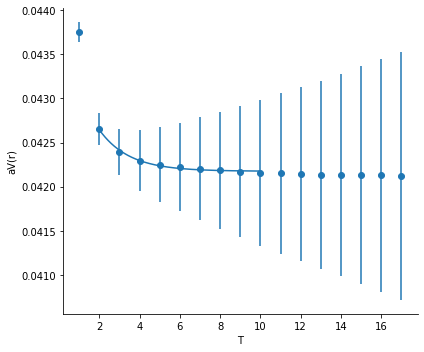

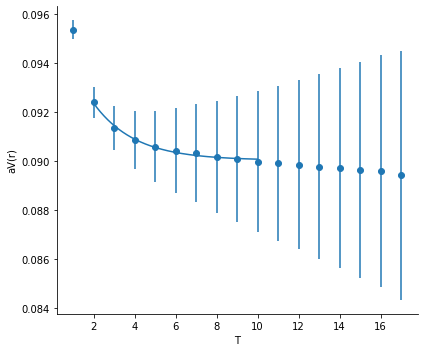

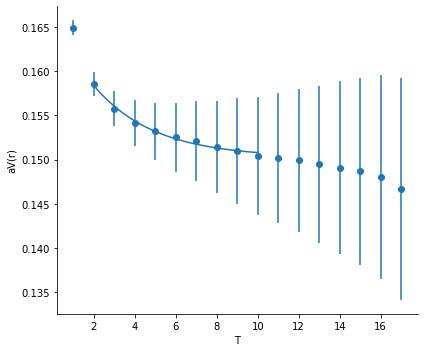

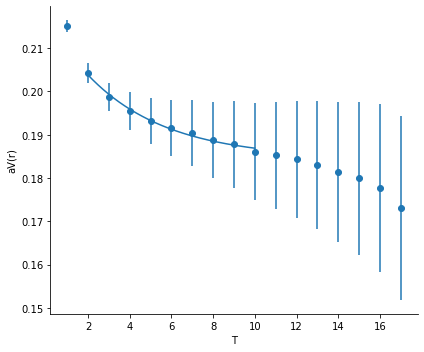

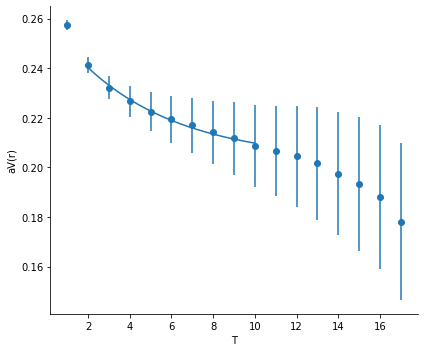

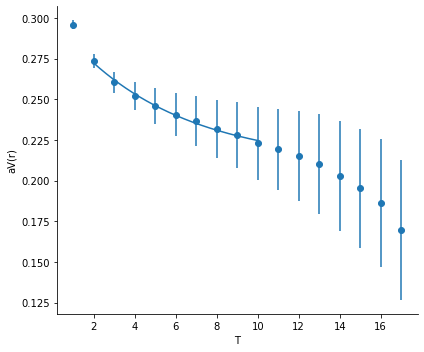

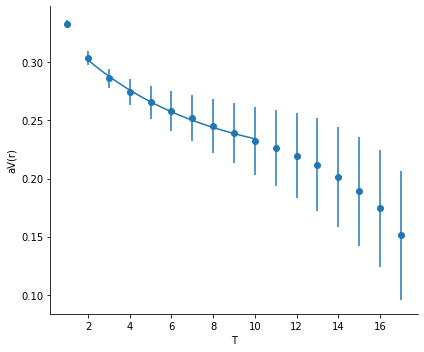

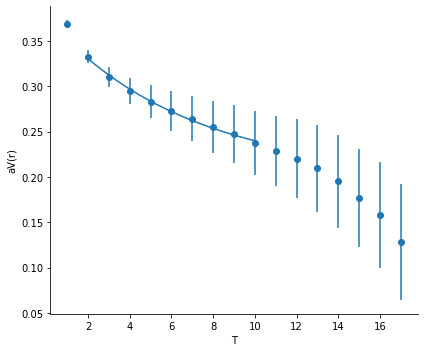

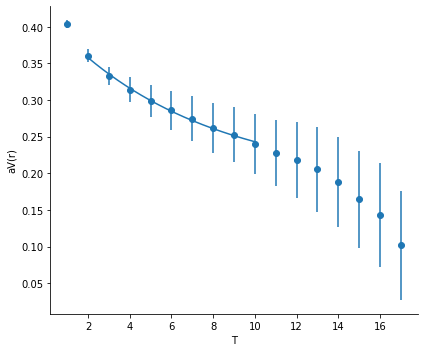

/home/ilya/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


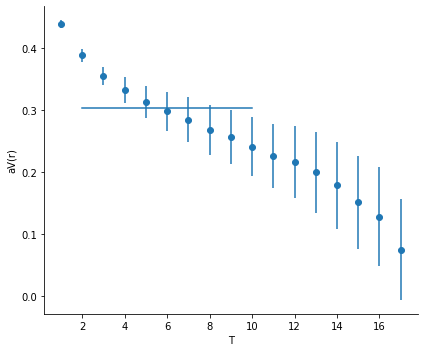

0.21154729529504324 -0.2523391681872307 0.0059686707426861866


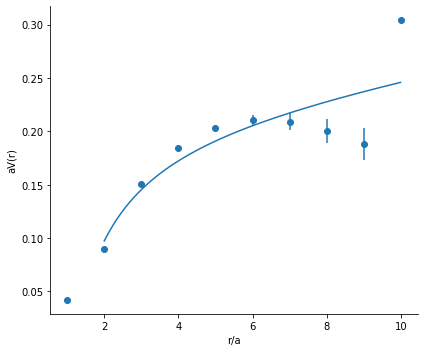

(0.0059686707426861866, 0.010099616490027058)

In [104]:
get_string_tension(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.25_nt=20", 2, 10, 'fitting')

In [98]:
def string_tension_dependence(nt):
    arr_mu = ['0.0', '0.25', '0.35', '0.45']
    string_tension = []
    string_tension_err = []

    for mu in arr_mu:
        sigma, err = get_string_tension(f"../result/potential/on-axis/su2/trunin/Wr_mu={mu}_nt={nt}", 2, 10, 'limit')
        string_tension.append(sigma)
        string_tension_err.append(err)

    print(string_tension)
    plt.errorbar(list(map(float, arr_mu)), string_tension)

In [ ]:
string_tension_dependence(20)

In [ ]:
string_tension_dependence(24)

In [ ]:
string_tension_dependence(28)

In [ ]:
string_tension_dependence(32)

In [ ]:
string_tension_dependence(36)

In [ ]:
string_tension_dependence(40)

In [ ]:
get_string_tension_test(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.0_nt=20", 2, 10)
get_string_tension_test(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.25_nt=20", 2, 10)
get_string_tension_test(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.35_nt=20", 2, 10)
get_string_tension_test(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.45_nt=20", 2, 10)